In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os.path as op
import glob
import matplotlib.pyplot as plt
import ast
# import moss
import csv
import random
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

from statsmodels.stats.anova import AnovaRM


In [2]:
df = pd.read_csv('pilot5_shuffled_nonresp_inc_ltm.csv')
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns


In [3]:
# df['Prioritized - Deprioritized IT Distractor Similarity'] = pd.Categorical(
#     df['Prioritized - Deprioritized IT Distractor Similarity'],
#     categories=['Least Similar', '', ' ', '   ', 'Most Similar'],
#     ordered=True
# )

# df['Prioritized - Deprioritized V2 Distractor Similarity'] = pd.Categorical(
#     df['Prioritized - Deprioritized V2 Distractor Similarity'],
#     categories=['Least Similar', '', ' ', '   ', 'Most Similar'],
#     ordered=True
# )
# df['V2 Distractor Similarity\nto Prioritized Item'] = pd.Categorical(
#     df['V2 Distractor Similarity\nto Prioritized Item'],
#     categories=['Least Similar', '', ' ', '   ', 'Most Similar'],
#     ordered=True
# )
# df['IT Distractor Similarity\nto Prioritized Item'] = pd.Categorical(
#     df['IT Distractor Similarity\nto Prioritized Item'],
#     categories=['Least Similar', '', ' ', '   ', 'Most Similar'],
#     ordered=True
# )
# df['V2 Distractor Similarity\nto Derioritized Item'] = pd.Categorical(
#     df['Prioritized - Deprioritized V2 Distractor Similarity'],
#     categories=['Least Similar', '', ' ', '   ', 'Most Similar'],
#     ordered=True
# )
# df['IT Distractor Similarity\nto Derioritized Item'] = pd.Categorical(
#     df['Prioritized - Deprioritized V2 Distractor Similarity'],
#     categories=['Least Similar', '', ' ', '   ', 'Most Similar'],
#     ordered=True
# )

In [4]:
df['Prioritized - Deprioritized IT Distractor Similarity'] 

0                     
1                     
2                  NaN
3         Most Similar
4                     
             ...      
40195              NaN
40196                 
40197    Least Similar
40198                 
40199              NaN
Name: Prioritized - Deprioritized IT Distractor Similarity, Length: 40200, dtype: object

In [5]:
def remove_unit_variance(df, col, unit, group=None, suffix="_within"):
    """Remove variance between sampling units.

    This is useful for plotting repeated-measures data using within-unit
    error bars.

    Parameters
    ----------
    df : DataFrame
        Input data. Will have a new column added.
    col : column name
        Column in dataframe with quantitative measure to modify.
    unit : column name
        Column in dataframe defining sampling units (e.g., subjects).
    group : column name(s), optional
        Columns defining groups to remove unit variance within.
    suffix : string, optional
        Suffix appended to ``col`` name to create new column.

    Returns
    -------
    df : DataFrame
        Returns modified dataframe.

    """
    new_col = col + suffix

    def demean(x):
        return x - x.mean()

    if group is None:
        new = df.groupby(unit)[col].transform(demean)
        new += df[col].mean()
        df.loc[:, new_col] = new
    else:
        df.loc[:, new_col] = np.nan
        for level, df_level in df.groupby(group):
            new = df_level.groupby(unit)[col].transform(demean)
            new += df_level[col].mean()
            df.loc[new.index, new_col] = new

    return df

In [6]:
df = remove_unit_variance(df,'mouse.time_last','participant')
df['analysis_rt'] = df['mouse.time_last_within']

In [7]:
palette = sns.color_palette("husl", n_colors=2)[::-1]  # Reverse the color order


In [8]:
# df['IT Distractor Similarity\nto Prioritized Item']

In [9]:
df['Distractor V2 Similarity Preference'] = df['v2_prefers'] 
df['Distractor IT Similarity Preference'] = df['it_prefers']


column_params = {
    'v2': {'n_cats': 5, 'labels': ['Least Similar', '', ' ', '   ', 'Most Similar']},
    'it': {'n_cats': 5, 'labels': ['Least Similar', '', ' ', '   ', 'Most Similar']}
}

for label in ['it_sim_dis_attend', 'v2_sim_dis_attend', 'it_sim_dis_unattend', 'v2_sim_dis_unattend', 'it_sim_dis_diff', 'v2_sim_dis_diff','v2_sim_dis_diff_sq', 'it_sim_dis_diff_sq']:
    
    if 'v2' in label:
        n_cats = column_params['v2']['n_cats']
        labels = column_params['v2']['labels']
    else:
        n_cats = column_params['it']['n_cats']
        labels = column_params['it']['labels']
    
    df[label + '_cat'] = pd.qcut(df[label], q=n_cats, labels=labels, duplicates='drop')


df['V2 Distractor Similarity\nto Prioritized Item'] = df['v2_sim_dis_attend_cat']
df['IT Distractor Similarity\nto Prioritized Item'] = df['it_sim_dis_attend_cat']
df['V2 Distractor Similarity\nto Deprioritized Item'] = df['v2_sim_dis_unattend_cat']
df['IT Distractor Similarity\nto Deprioritized Item'] = df['it_sim_dis_unattend_cat']
df['Prioritized - Deprioritized IT Distractor Similarity'] = df['it_sim_dis_diff_cat'] 
df['Prioritized - Deprioritized V2 Distractor Similarity'] = df['v2_sim_dis_diff_cat'] 
df['Prioritized - Deprioritized IT Distractor Similarity Squared'] = df['v2_sim_dis_diff_sq_cat'] 
df['Prioritized - Deprioritized V2 Distractor Similarity Squared'] = df['it_sim_dis_diff_sq_cat'] 


In [10]:
df['it_sim_dis_diff'] = df['it_sim_dis_diff'] - np.mean(df['it_sim_dis_diff'])
df['v2_sim_dis_diff'] = df['v2_sim_dis_diff'] - np.mean(df['v2_sim_dis_diff'])

df['it_sim_dis_diff_sq'] = [x**2 for x in df['it_sim_dis_diff']]
df['v2_sim_dis_diff_sq'] = [x**2 for x in df['v2_sim_dis_diff']]

df['it_sim_dis_diff_sq'] = df['it_sim_dis_diff_sq'] - np.mean(df['it_sim_dis_diff_sq'])
df['v2_sim_dis_diff_sq'] = df['v2_sim_dis_diff_sq'] - np.mean(df['v2_sim_dis_diff_sq'])


df['IT_diff_binned'] = pd.qcut(df['it_sim_dis_diff'], 5, duplicates='drop')
df['V2_diff_binned'] = pd.qcut(df['v2_sim_dis_diff'], 5, duplicates='drop')
df['IT_diff_binned_sq'] = pd.qcut(df['it_sim_dis_diff_sq'], 5, duplicates='drop')
df['V2_diff_binned_sq'] = pd.qcut(df['v2_sim_dis_diff_sq'], 5, duplicates='drop')

def round_to_significant_figures(x, sig_figs=2):
    if x == 0:
        return 0
    else:
        return round(x, sig_figs - int(np.floor(np.log10(abs(x)))) - 1)


def process_interval(interval):
    # Round both bounds
    lower_rounded = round_to_significant_figures(interval.left)
    upper_rounded = round_to_significant_figures(interval.right)
    # Return a new interval with the rounded bounds
    return pd.Interval(lower_rounded, upper_rounded)

df['IT_diff_binned'] = df['IT_diff_binned'].apply(process_interval)
df['V2_diff_binned'] = df['V2_diff_binned'].apply(process_interval)
df['IT_diff_binned_sq'] = df['IT_diff_binned_sq'].apply(process_interval)
df['V2_diff_binned_sq'] = df['V2_diff_binned_sq'].apply(process_interval)

df['Prioritized - Deprioritized V2 Distractor Similarity Ranges'] = df['V2_diff_binned']
df['Prioritized - Deprioritized IT Distractor Similarity Ranges'] = df['IT_diff_binned']
df['Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges'] = df['V2_diff_binned_sq']
df['Prioritized - Deprioritized IT Distractor Similarity Squared Ranges'] = df['IT_diff_binned_sq']

In [11]:
# df = df.loc[:, ~df.columns.duplicated()]

# # Convert binary variables to categorical data types
# df['reliability_binary'] = df['reliability'].astype('category')
# df['validity_binary'] = df['validity'].astype('category')

# # Fit the generalized linear model (GLM) with binomial family
# md = smf.glm(
#     "Accuracy ~ it_sim_dis_diff * reliability_binary * validity_binary + v2_sim_dis_diff * reliability_binary * validity_binary",
#     data=df,
#     family=sm.families.Binomial()
# ).fit()

# # Display the model summary
# print(md.summary())

In [101]:
df['v2_sim_dis_attend']

0        0.122014
1        0.062212
2        0.087158
3        0.073657
4        0.018378
           ...   
40195    0.110523
40196    0.148669
40197    0.063581
40198    0.153107
40199    0.069552
Name: v2_sim_dis_attend, Length: 40200, dtype: float64

In [12]:



md = smf.glm(
    "resp_correct ~ it_sim_dis_diff*reliability_binary*validity_binary \
        + v2_sim_dis_diff*reliability_binary*validity_binary",
    data=df,
    family=sm.families.Binomial()  
).fit()

# View the summary
md.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           resp_correct   No. Observations:                40200
Model:                            GLM   Df Residuals:                    40188
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -22297.
Date:                Tue, 12 Nov 2024   Deviance:                       44593.
Time:                        17:40:20   Pearson chi2:                 4.02e+04
No. Iterations:                     5   Pseudo R-squ. (CS):           0.007305
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                              0.9526      0.027     34.840      0.000       0.899       1.006
it_sim_dis_diff                                       -0.1480      0.037     -4.003      0.000      -0.220      -0.076
reliability_binary                                    -0.1923      0.046     -4.164      0.000      -0.283      -0.102
it_sim_dis_diff:reliability_binary                    -0.0147      0.063     -0.234      0.815      -0.138       0.108
validity_binary                                        0.1825      0.034      5.371      0.000       0.116       0.249
it_sim_dis_diff:validity_binary                        0.2829      0.046      6.137      0.000       0.193       0.373
reliability_binary:validity_binary                     0.3232      0.054      6.013      0.000       0.218       0.429
it_sim_dis_diff:reliability_binary:validity_binary    -0.0086      0.073     -0.118      0.906      -0.152       0.135
v2_sim_dis_diff                                       -0.7469      0.280     -2.672      0.008      -1.295      -0.199
v2_sim_dis_diff:reliability_binary                     1.0812      0.473      2.288      0.022       0.155       2.007
v2_sim_dis_diff:validity_binary                        1.2892      0.349      3.698      0.000       0.606       1.972
v2_sim_dis_diff:reliability_binary:validity_binary    -1.2422      0.551     -2.255      0.024      -2.322      -0.162
======================================================================================================================
"""

In [13]:


md = smf.glm(
    "Accuracy ~ it_sim_dis_diff*reliability_binary*validity_binary \
        + v2_sim_dis_diff*reliability_binary*validity_binary",
    data=df,
    family=sm.families.Binomial()  
).fit()

# View the summary
md.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Accuracy   No. Observations:                40200
Model:                            GLM   Df Residuals:                    40188
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21720.
Date:                Tue, 12 Nov 2024   Deviance:                   1.3907e+05
Time:                        17:40:20   Pearson chi2:                 3.65e+04
No. Iterations:                     5   Pseudo R-squ. (CS):           0.007200
Covariance Type:            nonrobust                                         
======================================================================================================================
                                                         coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                              0.9526      0.027     34.841      0.000       0.899       1.006
it_sim_dis_diff                                       -0.1409      0.037     -3.814      0.000      -0.213      -0.069
reliability_binary                                    -0.1923      0.046     -4.165      0.000      -0.283      -0.102
it_sim_dis_diff:reliability_binary                    -0.0220      0.063     -0.351      0.726      -0.145       0.101
validity_binary                                        0.1824      0.034      5.369      0.000       0.116       0.249
it_sim_dis_diff:validity_binary                        0.2771      0.046      6.012      0.000       0.187       0.367
reliability_binary:validity_binary                     0.3230      0.054      6.010      0.000       0.218       0.428
it_sim_dis_diff:reliability_binary:validity_binary    -0.0046      0.073     -0.063      0.950      -0.148       0.139
v2_sim_dis_diff                                       -0.8089      0.280     -2.893      0.004      -1.357      -0.261
v2_sim_dis_diff:reliability_binary                     1.0677      0.473      2.259      0.024       0.142       1.994
v2_sim_dis_diff:validity_binary                        1.3033      0.349      3.738      0.000       0.620       1.987
v2_sim_dis_diff:reliability_binary:validity_binary    -1.2593      0.551     -2.286      0.022      -2.339      -0.179
======================================================================================================================
"""

In [14]:
# df['v2_sim_dis_attend_cat']

In [15]:
# df['tested_item'] = df['Tested Item']
# df['ret_rel'] = df['Retrocue Reliability']

In [16]:
len(set(df['participant']))

134

In [17]:
df_correct = df[df['resp_correct'] == 1]


In [18]:
df

setup_js.started  setup_js.stopped  participant  \
0                   NaN               NaN       116851   
1                   NaN               NaN       116851   
2                   NaN               NaN       116851   
3                   NaN               NaN       116851   
4                   NaN               NaN       116851   
...                 ...               ...          ...   
40195               NaN               NaN       167080   
40196               NaN               NaN       167080   
40197               NaN               NaN       167080   
40198               NaN               NaN       167080   
40199               NaN               NaN       167080   

                          date     expName psychopyVersion        OS  \
0      2024-10-12 15:22:21.820  WM_Deepgen        2024.1.5     Win32   
1      2024-10-12 15:22:21.820  WM_Deepgen        2024.1.5     Win32   
2      2024-10-12 15:22:21.820  WM_Deepgen        2024.1.5     Win32   
3      2024-10-12 15:22:21.820  WM_Deepgen        2024.1.5     Win32   
4      2024-10-12 15:22:21.820  WM_Deepgen        2024.1.5     Win32   
...                        ...         ...             ...       ...   
40195  2024-10-28 17:42:43.597  WM_Deepgen        2023.2.1  MacIntel   
40196  2024-10-28 17:42:43.597  WM_Deepgen        2023.2.1  MacIntel   
40197  2024-10-28 17:42:43.597  WM_Deepgen        2023.2.1  MacIntel   
40198  2024-10-28 17:42:43.597  WM_Deepgen        2023.2.1  MacIntel   
40199  2024-10-28 17:42:43.597  WM_Deepgen        2023.2.1  MacIntel   

       frameRate  Instructions1.started  Instructions1.stopped  ...  \
0       59.52381                    NaN                    NaN  ...   
1       59.52381                    NaN                    NaN  ...   
2       59.52381                    NaN                    NaN  ...   
3       59.52381                    NaN                    NaN  ...   
4       59.52381                    NaN                    NaN  ...   
...          ...                    ...                    ...  ...   
40195   62.50000                    NaN                    NaN  ...   
40196   62.50000                    NaN                    NaN  ...   
40197   62.50000                    NaN                    NaN  ...   
40198   62.50000                    NaN                    NaN  ...   
40199   62.50000                    NaN                    NaN  ...   

       v2_sim_dis_diff_sq_cat  it_sim_dis_diff_sq_cat  \
0                                       Least Similar   
1               Least Similar           Least Similar   
2                                                       
3                                        Most Similar   
4                Most Similar                           
...                       ...                     ...   
40195           Least Similar                           
40196                                   Least Similar   
40197                                                   
40198                                                   
40199                                                   

       Prioritized - Deprioritized IT Distractor Similarity Squared  \
0                                                                     
1                                          Least Similar              
2                                                                     
3                                                                     
4                                           Most Similar              
...                                                  ...              
40195                                      Least Similar              
40196                                                                 
40197                                                                 
40198                                                                 
40199                                                                 

       Prioritized - Deprioritized V2 Distractor Simil

<Figure size 1000x600 with 0 Axes>

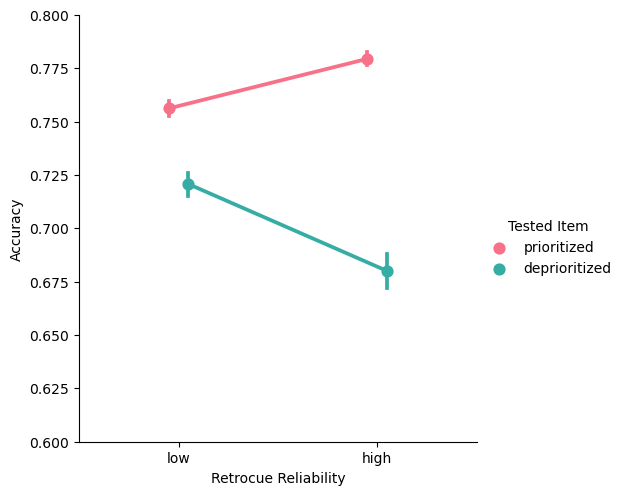

In [19]:

plt.figure(figsize=(10, 6))
sns.catplot(
    x='Retrocue Reliability',
    y='Accuracy',
    errorbar=('ci', 68),  # Updated error bar parameter
    order = ['low','high'],
#     col = 'participant',
    kind = 'point',
    hue='Tested Item',
    dodge=0.1,
    palette=palette[::-1],  # Use the single-color palette
    data=df
)
plt.ylim(0.6, 0.8)
plt.ylabel('Accuracy')
# plt.xlabel('V2 Distractor Similarity to Prioritized Item')
# plt.title('Accuracy by V2 Distractor Similarity')
plt.show()


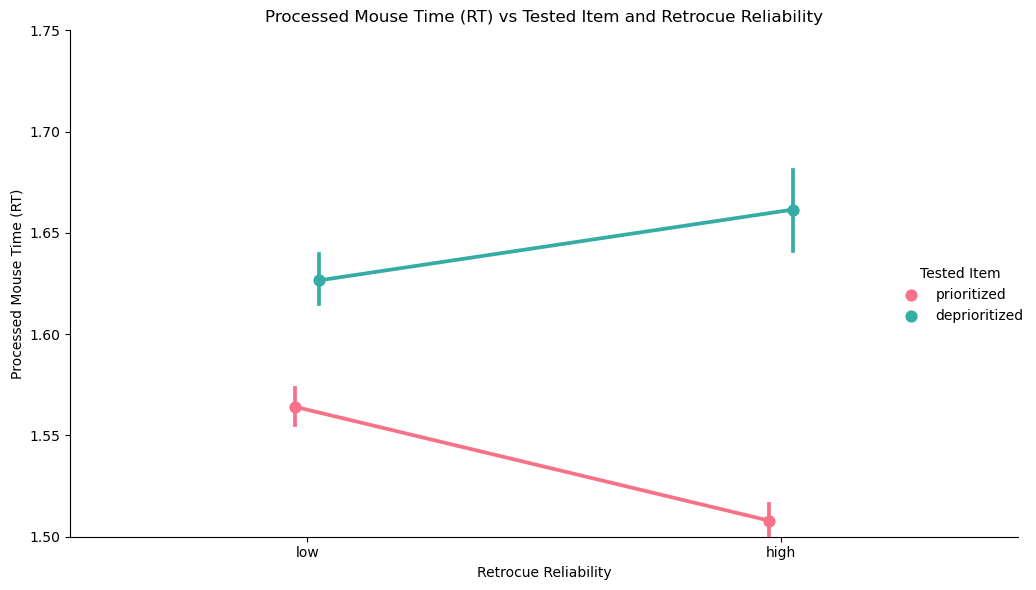

In [20]:
g = sns.catplot(x='Retrocue Reliability', y='analysis_rt', hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            order=['low', 'high'],  # Specify the order of the categories
            palette = palette[::-1])
g.set(ylim=(1.5, 1.75))

plt.xlabel('Retrocue Reliability')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs Tested Item and Retrocue Reliability')
plt.tight_layout()
plt.show()

In [21]:
# df['V2 Distractor Similarity\nto Prioritized Item']

In [22]:
# nan_values = df['V2 Distractor Similarity\nto Prioritized Item'].isna()
# rows_with_nan = df[nan_values]
# print(rows_with_nan)


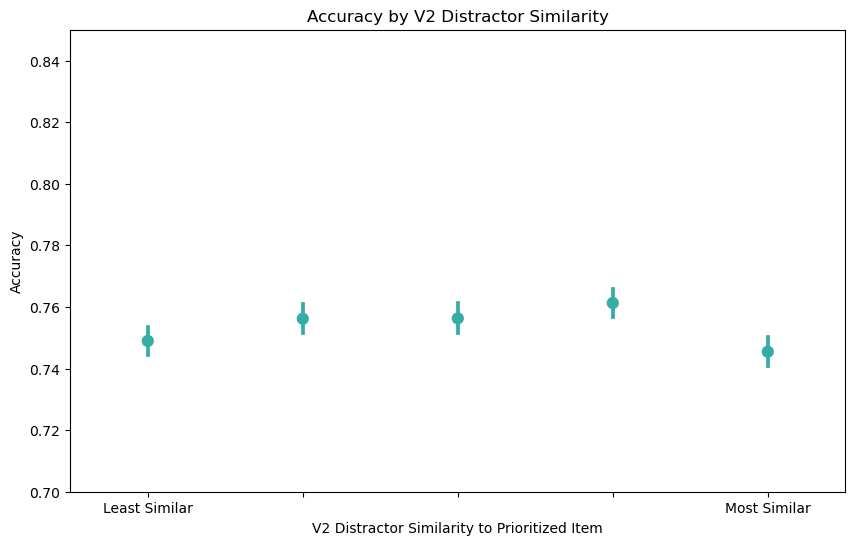

In [23]:
single_color = palette[0]  # Use the first color from the palette
single_color_palette = [single_color]

plt.figure(figsize=(10, 6))
sns.pointplot(
    x='V2 Distractor Similarity\nto Prioritized Item',
    y='Accuracy',
    errorbar=('ci', 68),  # Updated error bar parameter
    dodge=0.1,
    palette=single_color_palette,  # Use the single-color palette
    data=df
)
plt.ylim(0.7, 0.85)
plt.ylabel('Accuracy')
plt.xlabel('V2 Distractor Similarity to Prioritized Item')
plt.title('Accuracy by V2 Distractor Similarity')
plt.show()


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/1190682690.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(44.99652777777777, 0.5, 'Accuracy')

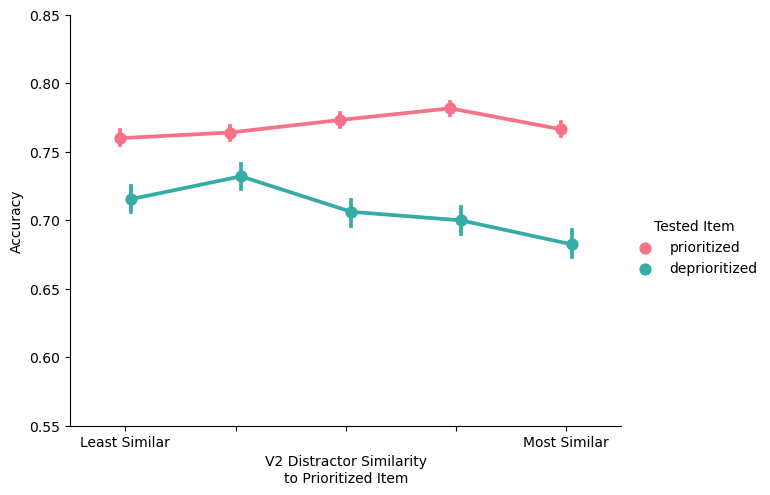

In [24]:
g = sns.catplot(
            x = 'V2 Distractor Similarity\nto Prioritized Item',
            y = 'Accuracy',
            ci = 68,
            hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            palette = palette[::-1],  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.ylabel('Accuracy')


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/1289384816.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(45.877985517568845, 0.5, 'Accuracy')

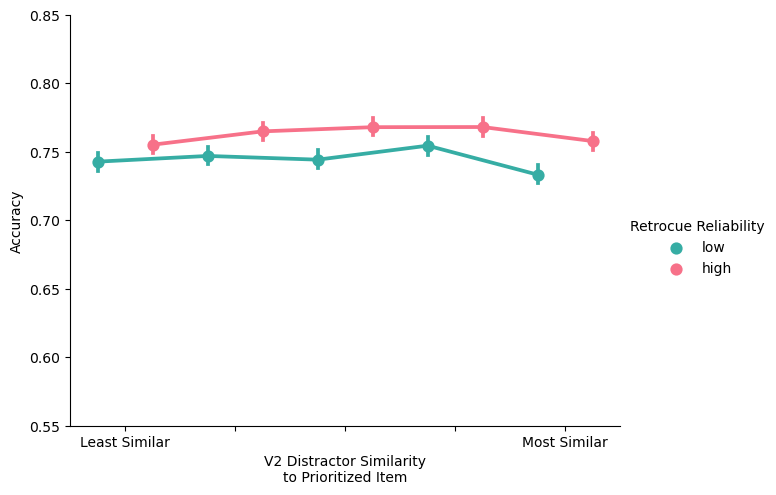

In [25]:
g = sns.catplot(
            x = 'V2 Distractor Similarity\nto Prioritized Item',
            y = 'Accuracy',
            ci = 68,
            hue = 'Retrocue Reliability',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.5,
            kind = 'point',
            palette = palette,  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.ylabel('Accuracy')


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/3059318271.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


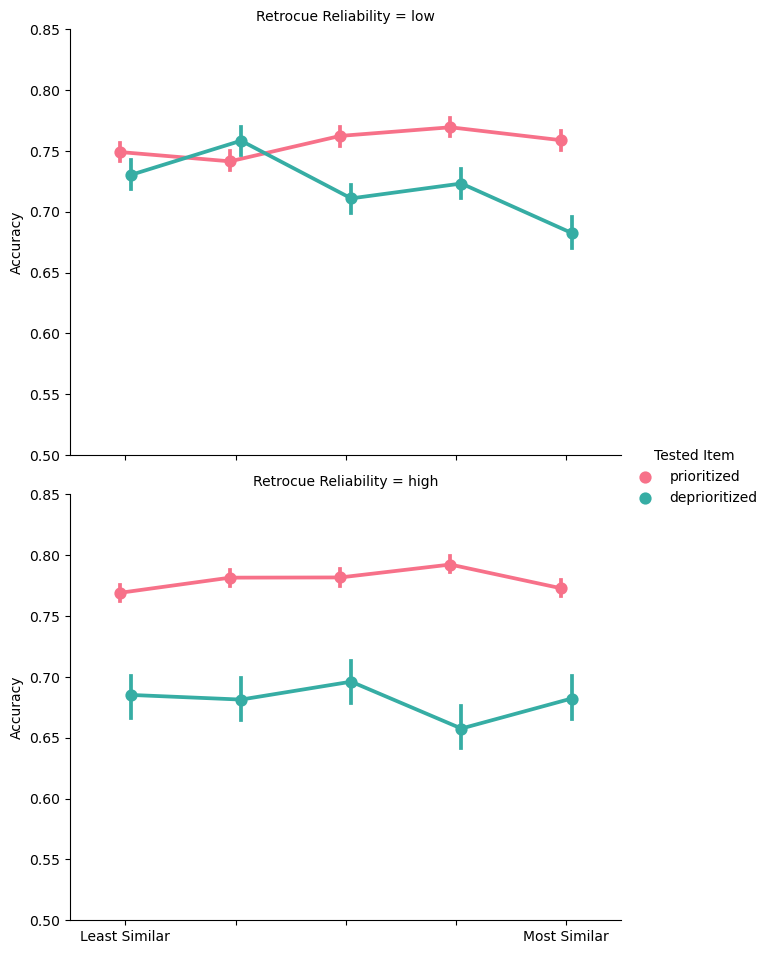

In [26]:
g = sns.catplot(
    x='V2 Distractor Similarity\nto Prioritized Item',
    y='Accuracy',
    ci=68,
    hue='Tested Item',
    row='Retrocue Reliability',  # Use 'row' instead of 'col' to arrange plots vertically
    aspect=1.3,
    dodge=0.1,
    kind='point',
    row_order = ['low', 'high'],
    palette=palette[::-1],  # Reverse the color order
    data=df
)
g.set(ylim=(0.50, 0.85))
g.set_axis_labels("", "Accuracy")

plt.show()

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/3108638688.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


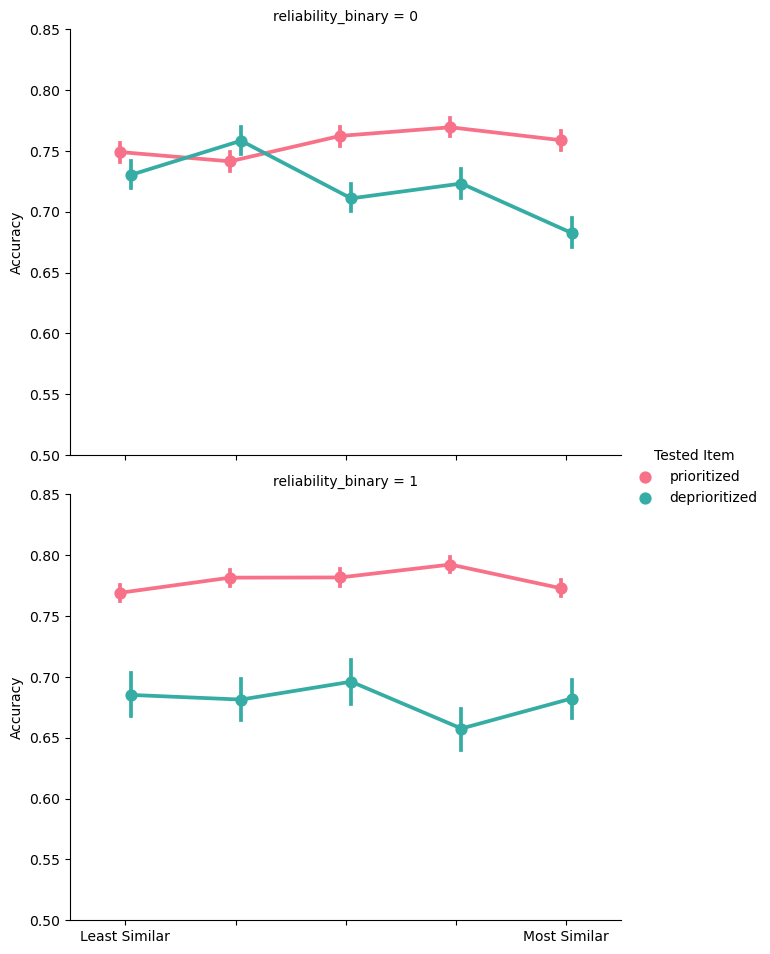

In [27]:
g = sns.catplot(
    x='V2 Distractor Similarity\nto Prioritized Item',
    y='Accuracy',
    ci=68,
    hue='Tested Item',
    row='reliability_binary',  # Use 'row' instead of 'col' to arrange plots vertically
    aspect=1.3,
    dodge=0.1,
    kind='point',
#     row_order = ['low', 'high'],
    palette=palette[::-1],  # Reverse the color order
    data=df
)
g.set(ylim=(0.50, 0.85))
g.set_axis_labels("", "Accuracy")

plt.show()

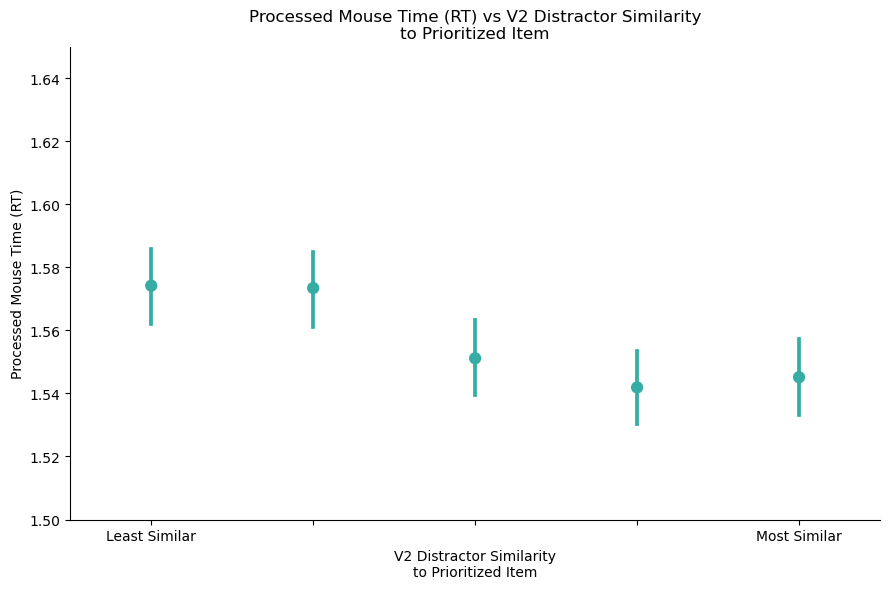

In [28]:
g = sns.catplot(x='V2 Distractor Similarity\nto Prioritized Item', y='analysis_rt', 
#                 hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            # order=['Least Similar', ' ', ' ', ' ', 'Most Similar'],  # Specify the order of the categories
            palette = single_color_palette  # Reverse the color order
)
g.set(ylim=(1.5, 1.65))

plt.xlabel('V2 Distractor Similarity\nto Prioritized Item')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs V2 Distractor Similarity\nto Prioritized Item')
plt.tight_layout()
plt.show()

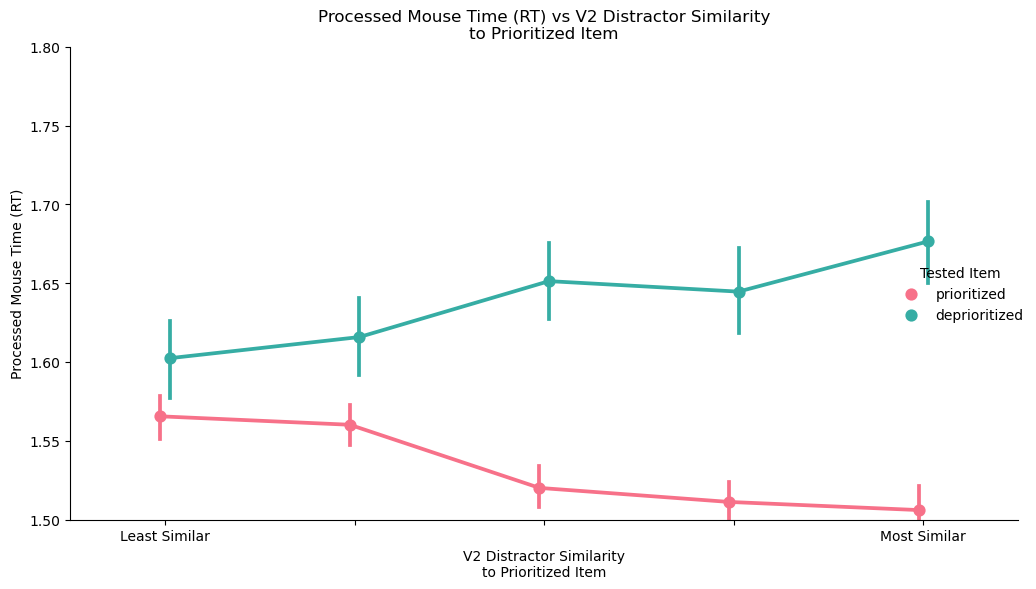

In [29]:
g = sns.catplot(x='V2 Distractor Similarity\nto Prioritized Item', y='analysis_rt', 
                hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette[::-1]  # Reverse the color order
)
g.set(ylim=(1.5, 1.8))

plt.xlabel('V2 Distractor Similarity\nto Prioritized Item')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs V2 Distractor Similarity\nto Prioritized Item')
plt.tight_layout()
plt.show()

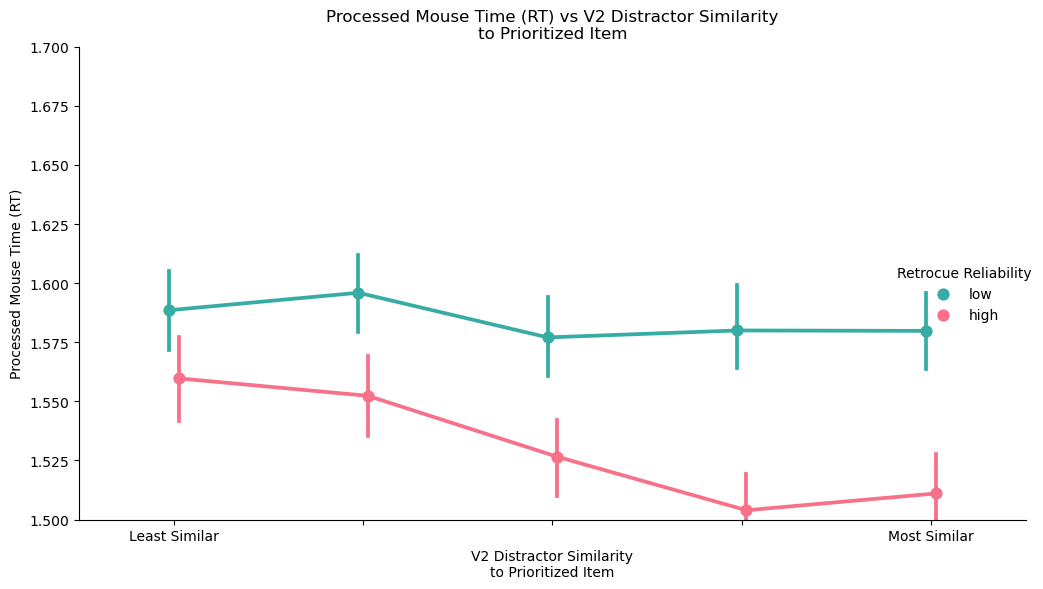

In [30]:
g = sns.catplot(x='V2 Distractor Similarity\nto Prioritized Item', y='analysis_rt', 
                hue='Retrocue Reliability', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette  # Reverse the color order
)
g.set(ylim=(1.5, 1.7))

plt.xlabel('V2 Distractor Similarity\nto Prioritized Item')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs V2 Distractor Similarity\nto Prioritized Item')
plt.tight_layout()
plt.show()

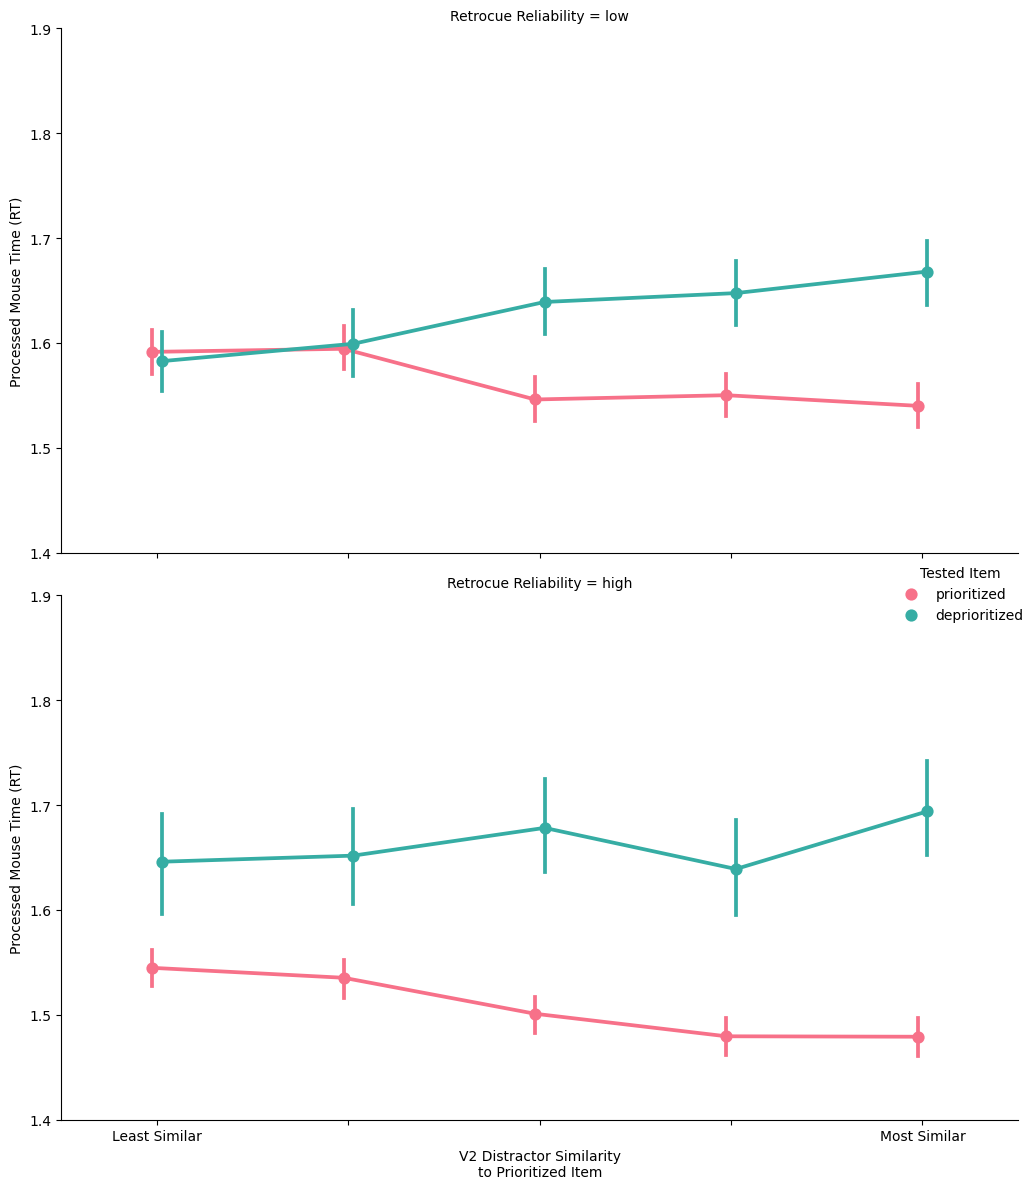

In [31]:
g = sns.catplot(x='V2 Distractor Similarity\nto Prioritized Item', y='analysis_rt', 
                hue='Tested Item', row='Retrocue Reliability',  # Use 'row' instead of 'col'
                kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
                palette=palette[::-1]  # Reverse the color order
)
g.set(ylim=(1.4, 1.9))

g.set_axis_labels('V2 Distractor Similarity\nto Prioritized Item', 'Processed Mouse Time (RT)')
plt.tight_layout()
plt.show()

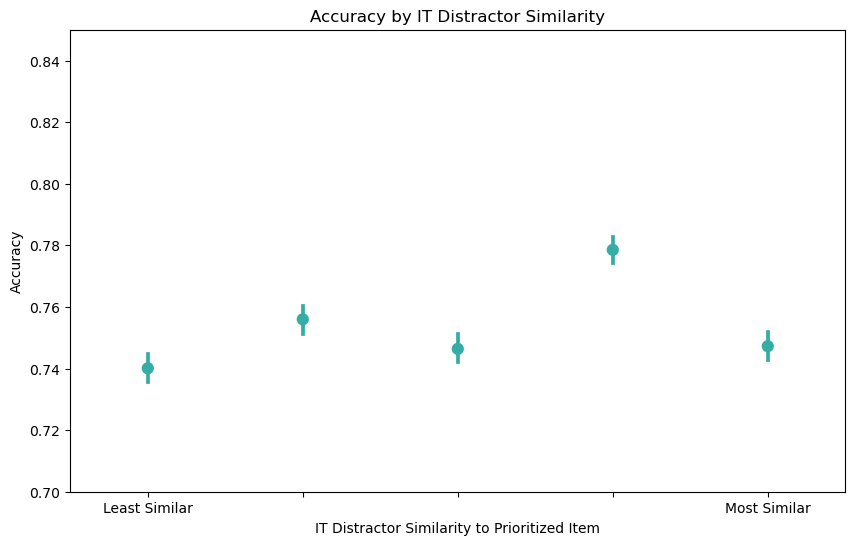

In [32]:


plt.figure(figsize=(10, 6))
sns.pointplot(
    x='IT Distractor Similarity\nto Prioritized Item',
    y='Accuracy',
    errorbar=('ci', 68),  # Updated error bar parameter
    dodge=0.1,
    palette=single_color_palette,  # Use the single-color palette
    data=df
)
plt.ylim(0.7, 0.85)
plt.ylabel('Accuracy')
plt.xlabel('IT Distractor Similarity to Prioritized Item')
plt.title('Accuracy by IT Distractor Similarity')
plt.show()


In [33]:
df['validity_binary'] = df['Tested Item'].apply(lambda x: 1 if x == 'prioritized' else 0)
df['reliability_binary'] = df['Retrocue Reliability'].apply(lambda x: 1 if x == 'high' else 0)


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/2234716875.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


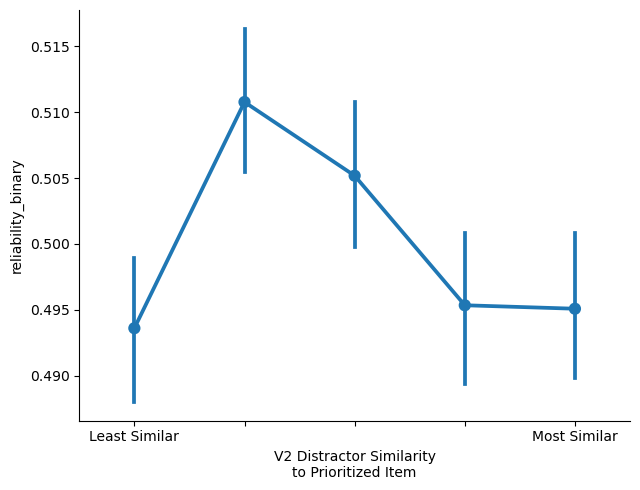

In [34]:

# plt.figure(figsize=(10, 6))
# sns.pointplot(
#     x='IT Distractor Similarity\nto Prioritized Item',
#     y='Tested Item',
#     errorbar=('ci', 68),  # Updated error bar parameter
#     dodge=0.5,
#     palette=single_color_palette,  # Use the single-color palette
#     data=df
# )
# plt.ylim(0.7, 0.85)
# plt.ylabel('Accuracy')
# plt.xlabel('IT Distractor Similarity to Prioritized Item')
# plt.title('Accuracy by IT Distractor Similarity')
# plt.show()



g = sns.catplot(
    x='V2 Distractor Similarity\nto Prioritized Item',
    y='reliability_binary',
    ci=68,
#     hue='Tested Item',
#     row='Retrocue Reliability',  # Use 'row' instead of 'col' to arrange plots vertically
    aspect=1.3,
    dodge=0.1,
    kind='point',
    row_order = ['low', 'high'],
#     palette=palette,  # Reverse the color order
    data=df)


plt.show()

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/2990378629.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(44.99652777777777, 0.5, 'Accuracy')

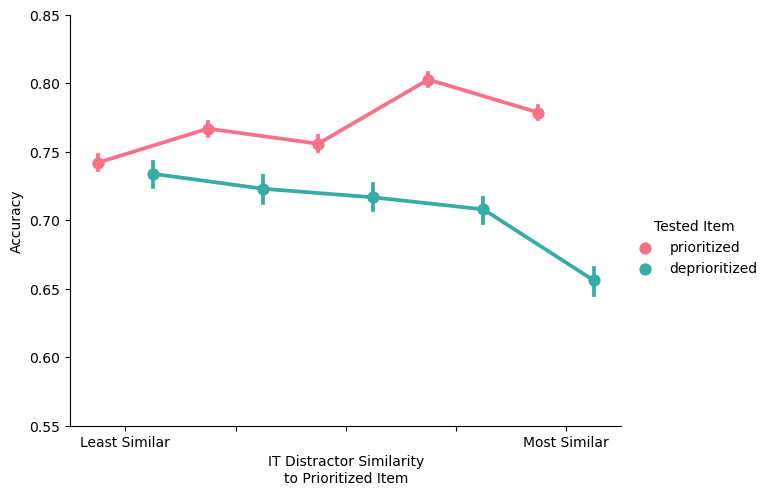

In [35]:
g = sns.catplot(
            x = 'IT Distractor Similarity\nto Prioritized Item',
            y = 'Accuracy',
            ci = 68,
            hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.5,
            kind = 'point',
            palette = palette[::-1],  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.ylabel('Accuracy')

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/2304160147.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(45.877985517568845, 0.5, 'Accuracy')

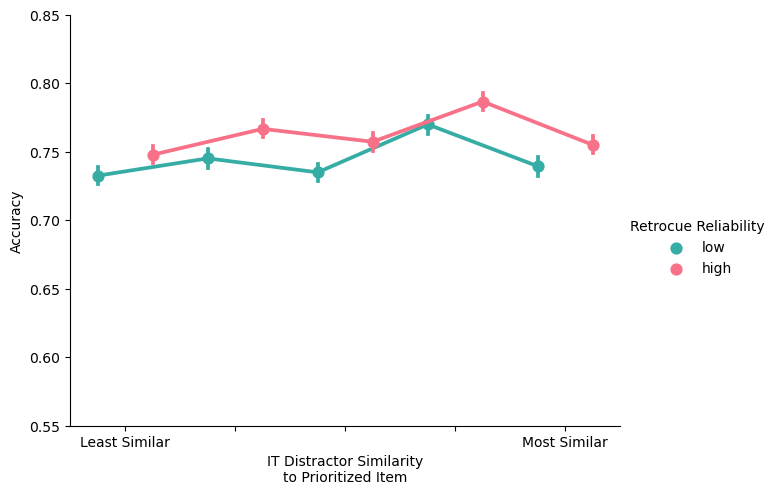

In [36]:
g = sns.catplot(
            x = 'IT Distractor Similarity\nto Prioritized Item',
            y = 'Accuracy',
            ci = 68,
            hue = 'Retrocue Reliability',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.5,
            kind = 'point',
            palette = palette,  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.ylabel('Accuracy')

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/2385623800.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


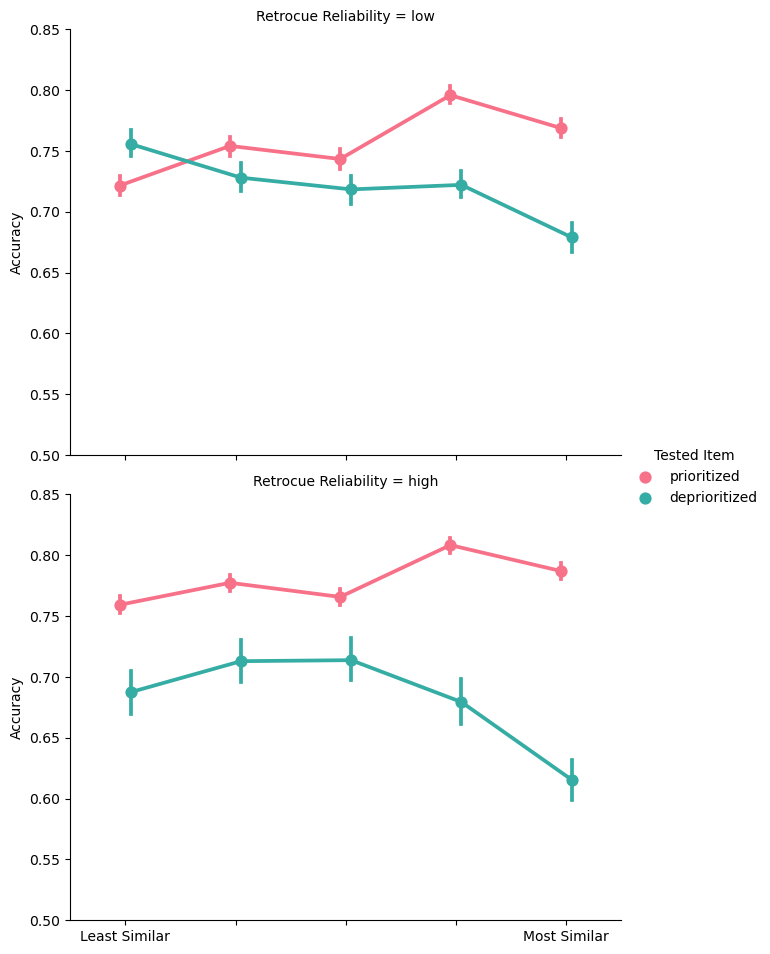

In [37]:
g = sns.catplot(
    x='IT Distractor Similarity\nto Prioritized Item',
    y='Accuracy',
    ci=68,
    hue='Tested Item',
    
    row='Retrocue Reliability',  # Use 'row' instead of 'col' to arrange plots vertically
    aspect=1.3,
    row_order = ['low', 'high'],
    dodge=0.1,
    kind='point',
    palette=palette[::-1],  # Reverse the color order
    data=df
)
g.set(ylim=(0.5, 0.85))
g.set_axis_labels("", "Accuracy")

plt.show()

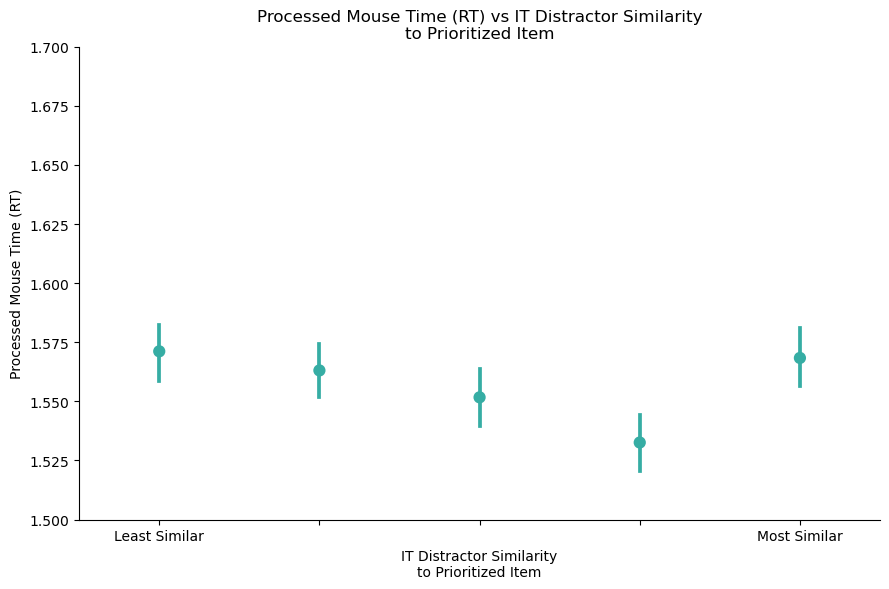

In [38]:
g = sns.catplot(x='IT Distractor Similarity\nto Prioritized Item', y='analysis_rt', 
#                 hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            # order=['Least Similar', ' ', ' ', ' ', 'Most Similar'],  # Specify the order of the categories
            palette = single_color_palette  # Reverse the color order
)
g.set(ylim=(1.5, 1.7))

plt.xlabel('IT Distractor Similarity\nto Prioritized Item')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs IT Distractor Similarity\nto Prioritized Item')
plt.tight_layout()
plt.show()

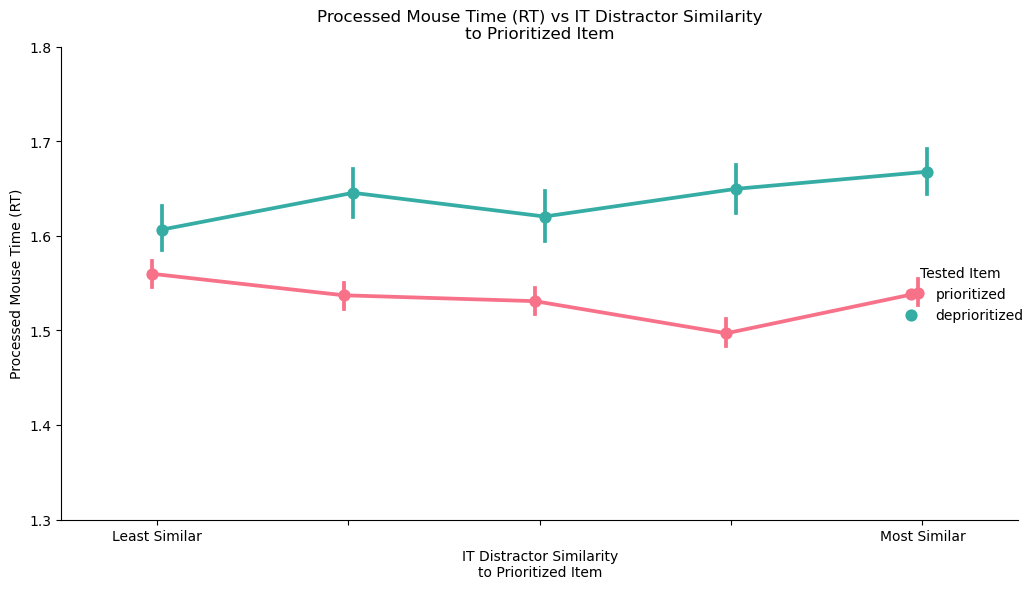

In [39]:
g = sns.catplot(x='IT Distractor Similarity\nto Prioritized Item', y='analysis_rt', 
                hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette[::-1]  # Reverse the color order
)
g.set(ylim=(1.3, 1.8))

plt.xlabel('IT Distractor Similarity\nto Prioritized Item')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs IT Distractor Similarity\nto Prioritized Item')
plt.tight_layout()
plt.show()

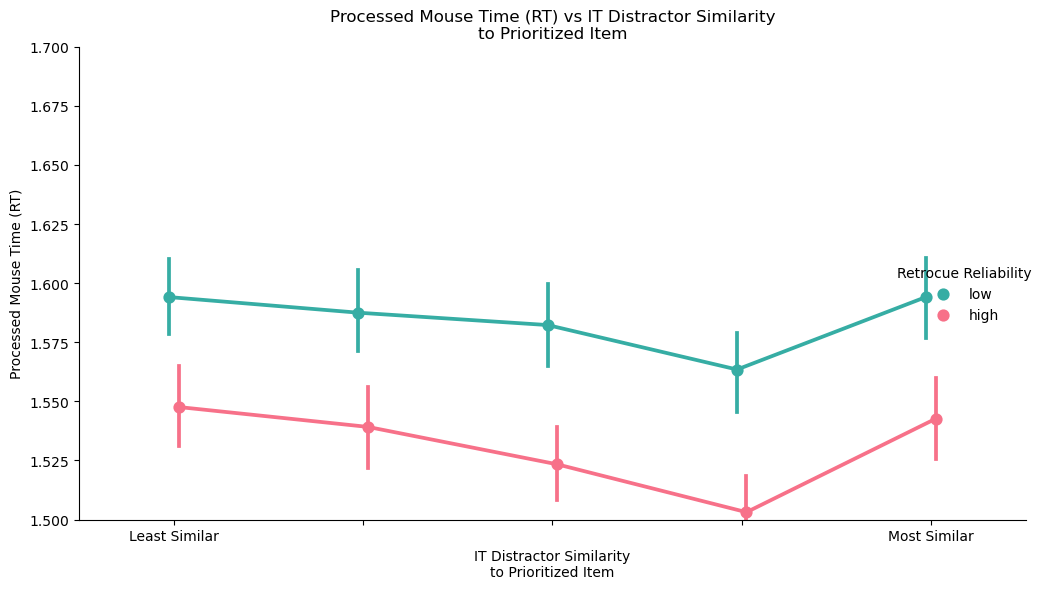

In [40]:
g = sns.catplot(x='IT Distractor Similarity\nto Prioritized Item', y='analysis_rt', 
                hue='Retrocue Reliability', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette  # Reverse the color order
)
g.set(ylim=(1.5, 1.7))

plt.xlabel('IT Distractor Similarity\nto Prioritized Item')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs IT Distractor Similarity\nto Prioritized Item')
plt.tight_layout()
plt.show()

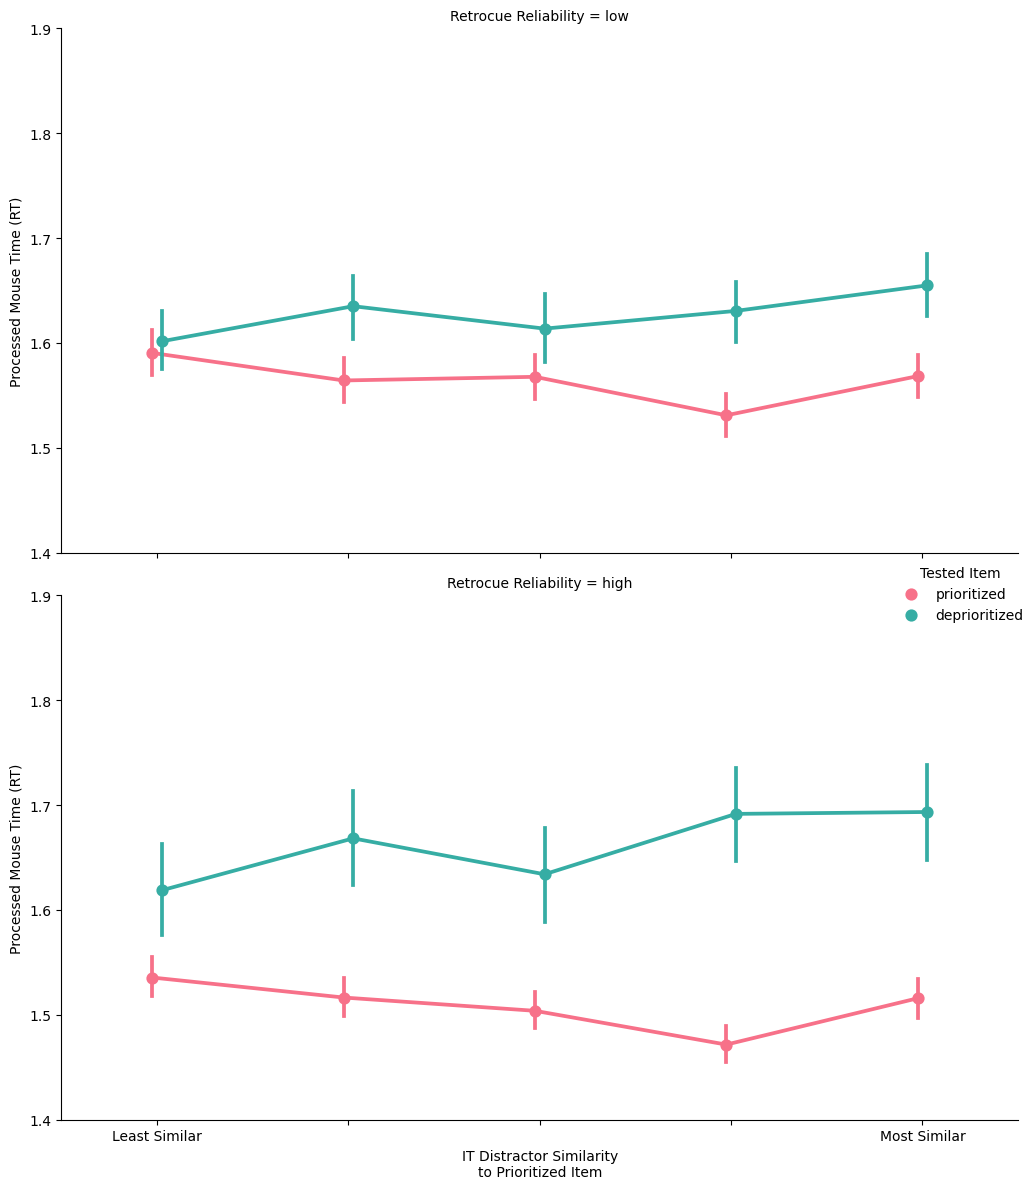

In [41]:
g = sns.catplot(x='IT Distractor Similarity\nto Prioritized Item', y='analysis_rt', 
                hue='Tested Item', row='Retrocue Reliability',  # Use 'row' instead of 'col'
                kind='point',row_order = ['low', 'high'], data=df_correct, dodge=True, height=6, aspect=1.5, 
                palette=palette[::-1]  # Reverse the color order
)
g.set(ylim=(1.4, 1.9))

g.set_axis_labels('IT Distractor Similarity\nto Prioritized Item', 'Processed Mouse Time (RT)')
plt.tight_layout()
plt.show()

In [42]:
# df['IT_diff_binned'] = pd.qcut(df['it_sim_dis_diff'], 5, duplicates='drop')
# df['V2_diff_binned'] = pd.qcut(df['v2_sim_dis_diff'], 5, duplicates='drop')

# def round_to_significant_figures(x, sig_figs=2):
#     if x == 0:
#         return 0
#     else:
#         return round(x, sig_figs - int(np.floor(np.log10(abs(x)))) - 1)


# def process_interval(interval):
#     # Round both bounds
#     lower_rounded = round_to_significant_figures(interval.left)
#     upper_rounded = round_to_significant_figures(interval.right)
#     # Return a new interval with the rounded bounds
#     return pd.Interval(lower_rounded, upper_rounded)

# df['IT_diff_binned'] = df['IT_diff_binned'].apply(process_interval)
# df['V2_diff_binned'] = df['V2_diff_binned'].apply(process_interval)

# df['Prioritized - Deprioritized V2 Distractor Similarity Ranges'] = df['V2_diff_binned']
# df['Prioritized - Deprioritized IT Distractor Similarity Ranges'] = df['IT_diff_binned']

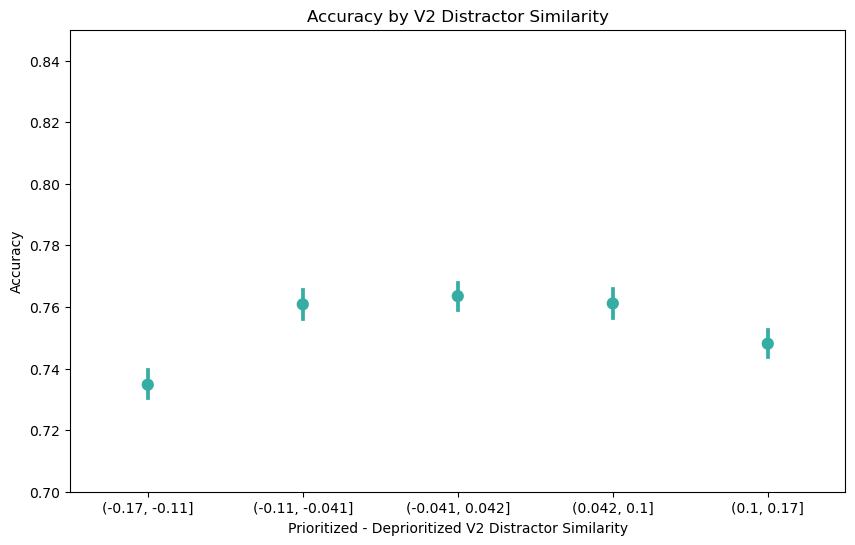

In [43]:
plt.figure(figsize=(10, 6))
sns.pointplot(
    x='V2_diff_binned',
    y='Accuracy',
    errorbar=('ci', 68),  # Updated error bar parameter
    dodge=0.1,
    palette=single_color_palette,  # Use the single-color palette
    data=df
)
plt.ylim(0.7, 0.85)
plt.ylabel('Accuracy')
plt.xlabel('Prioritized - Deprioritized V2 Distractor Similarity')
plt.title('Accuracy by V2 Distractor Similarity')
plt.show()

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/741286795.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(44.99652777777777, 0.5, 'Accuracy')

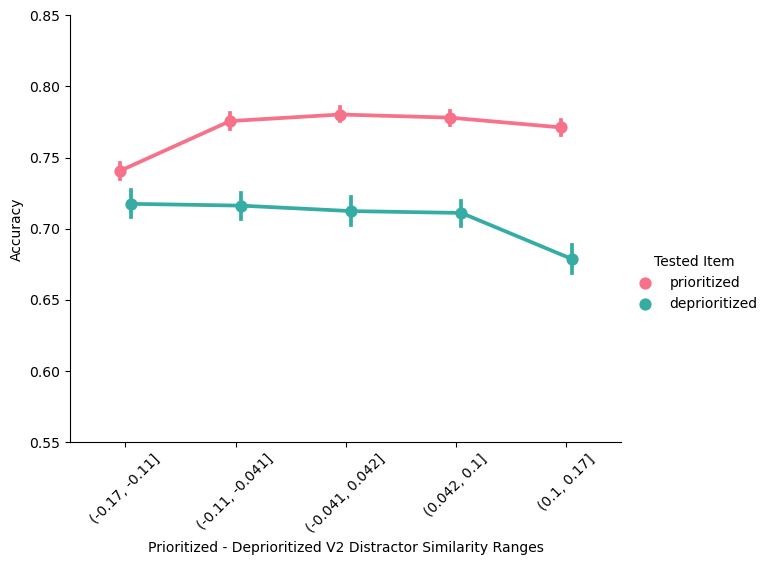

In [44]:
g = sns.catplot(
            x = 'Prioritized - Deprioritized V2 Distractor Similarity Ranges',
            y = 'Accuracy',
            ci = 68,
            hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = palette[::-1],  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/1754270446.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(45.877985517568845, 0.5, 'Accuracy')

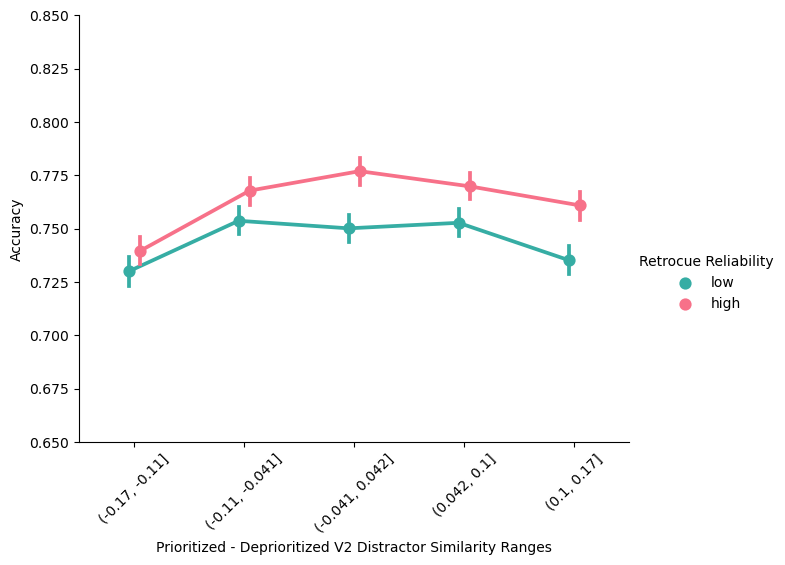

In [45]:



g = sns.catplot(
            x = 'Prioritized - Deprioritized V2 Distractor Similarity Ranges',
            y = 'Accuracy',
            ci = 68,
            hue = 'Retrocue Reliability',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = palette,  # Reverse the color order
            data = df)
g.set(ylim=(0.65, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')



/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/1572650511.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


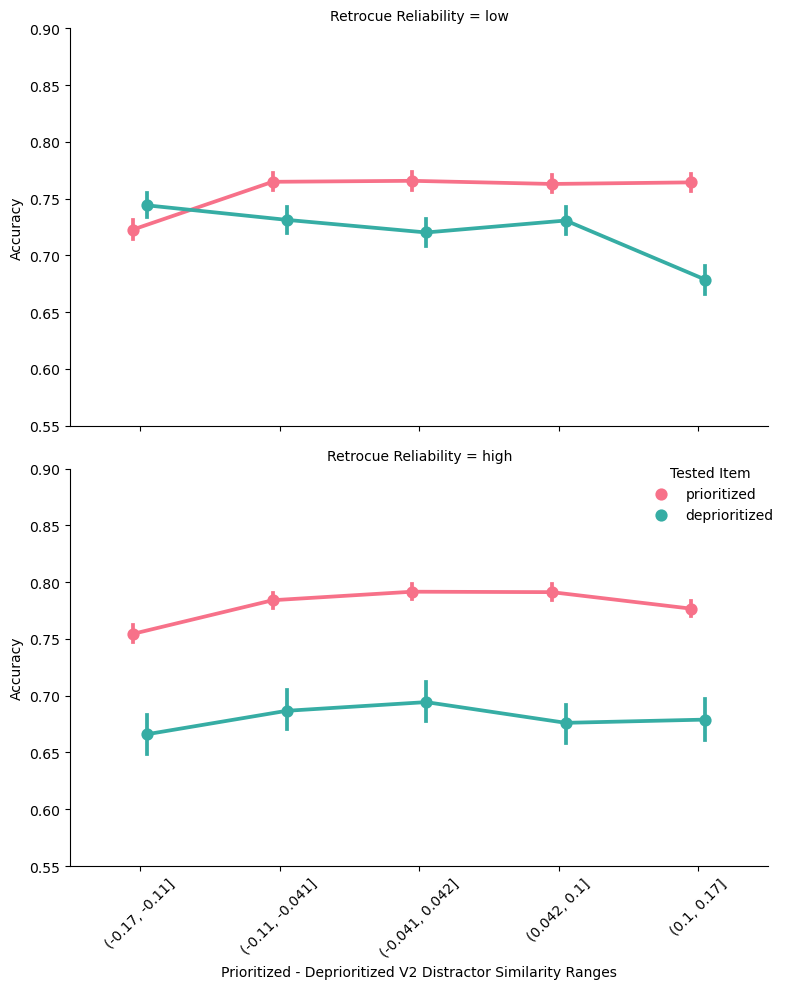

In [46]:


g = sns.catplot(
    x='Prioritized - Deprioritized V2 Distractor Similarity Ranges',
    y='Accuracy',
    ci=68,
    hue='Tested Item',
    row='Retrocue Reliability',  # Use 'row' instead of 'col'
    aspect=1.3,
    row_order = ['low', 'high'],
    dodge=0.1,
    kind='point',
    palette=palette[::-1],  # Use the reversed color order
    data=df
)
g.set(ylim=(0.55, 0.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

g.set_axis_labels("Prioritized - Deprioritized V2 Distractor Similarity Ranges", "Accuracy")
plt.tight_layout()
plt.show()

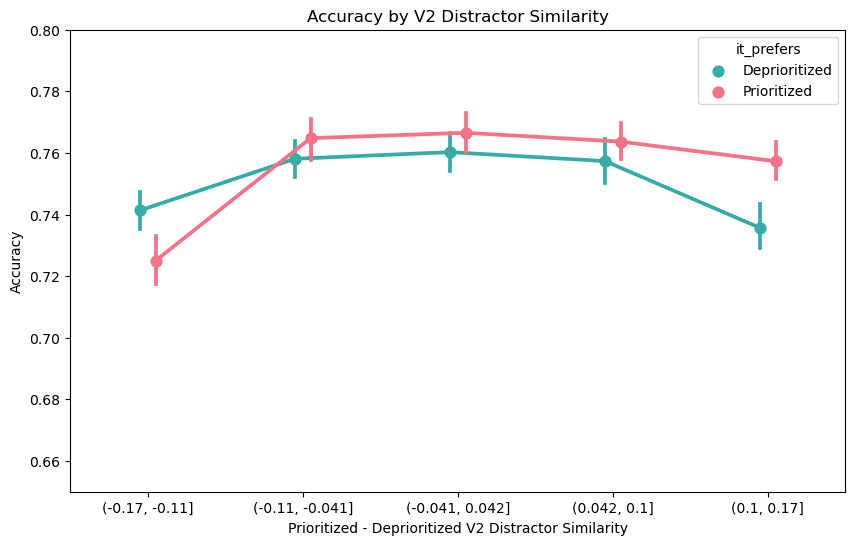

In [47]:
plt.figure(figsize=(10, 6))
sns.pointplot(
    x='V2_diff_binned',
    y='Accuracy',
    hue = 'it_prefers',
    errorbar=('ci', 68),  # Updated error bar parameter
    dodge=0.1,
    palette=palette,  # Use the single-color palette
    data=df
)
plt.ylim(0.65, 0.8)
plt.ylabel('Accuracy')
plt.xlabel('Prioritized - Deprioritized V2 Distractor Similarity')
plt.title('Accuracy by V2 Distractor Similarity')
plt.show()

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/2612231446.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(44.99652777777777, 0.5, 'Accuracy')

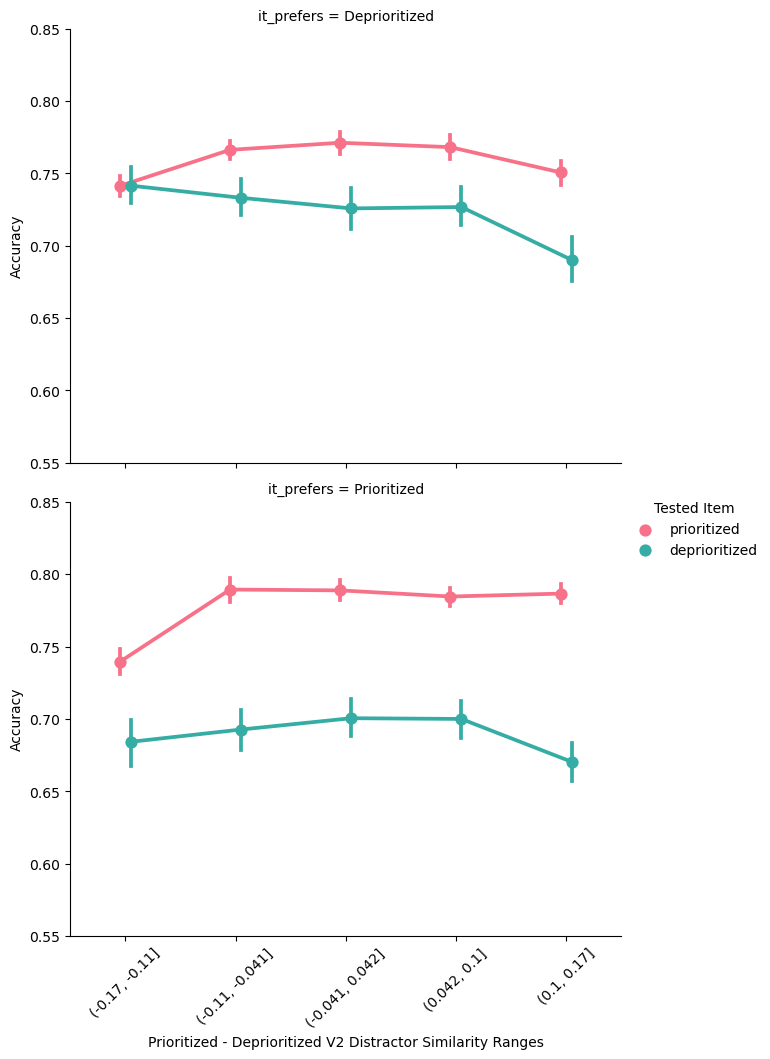

In [48]:
g = sns.catplot(
            x = 'Prioritized - Deprioritized V2 Distractor Similarity Ranges',
            y = 'Accuracy',
            ci = 68,
            row = 'it_prefers',
            hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = palette[::-1],  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')

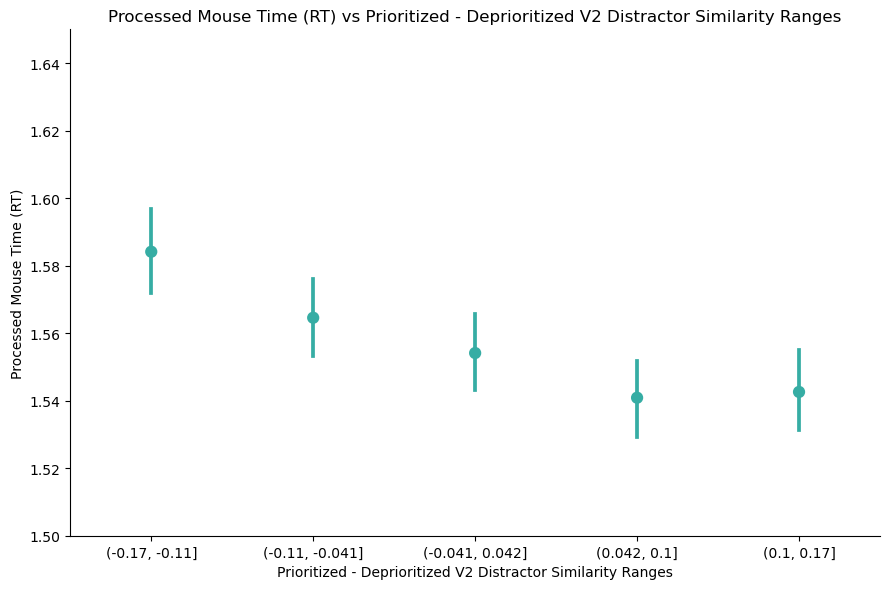

In [49]:
g = sns.catplot(x='Prioritized - Deprioritized V2 Distractor Similarity Ranges', y='analysis_rt', 
#                 hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            # order=['Least Similar', ' ', ' ', ' ', 'Most Similar'],  # Specify the order of the categories
            palette = single_color_palette  # Reverse the color order
)
g.set(ylim=(1.5, 1.65))

plt.xlabel('Prioritized - Deprioritized V2 Distractor Similarity Ranges')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs Prioritized - Deprioritized V2 Distractor Similarity Ranges')
plt.tight_layout()
plt.show()

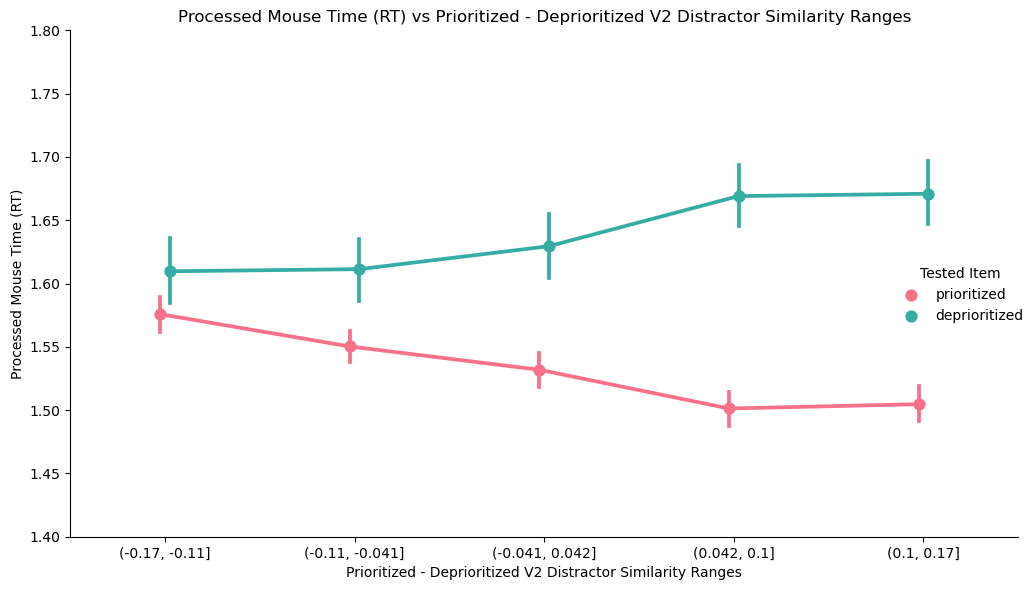

In [50]:
g = sns.catplot(x='Prioritized - Deprioritized V2 Distractor Similarity Ranges', y='analysis_rt', 
                hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette[::-1]  # Reverse the color order
)
g.set(ylim=(1.4, 1.8))

plt.xlabel('Prioritized - Deprioritized V2 Distractor Similarity Ranges')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs Prioritized - Deprioritized V2 Distractor Similarity Ranges')
plt.tight_layout()
plt.show()

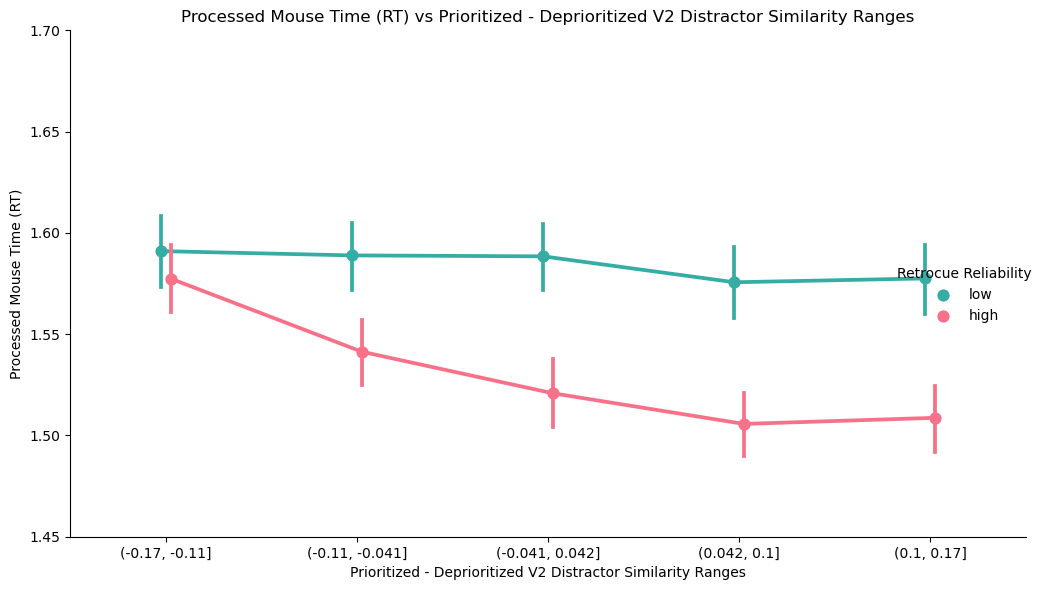

In [51]:
g = sns.catplot(x='Prioritized - Deprioritized V2 Distractor Similarity Ranges', y='analysis_rt', 
                hue='Retrocue Reliability', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette  # Reverse the color order
)
g.set(ylim=(1.45, 1.7))

plt.xlabel('Prioritized - Deprioritized V2 Distractor Similarity Ranges')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs Prioritized - Deprioritized V2 Distractor Similarity Ranges')
plt.tight_layout()
plt.show()

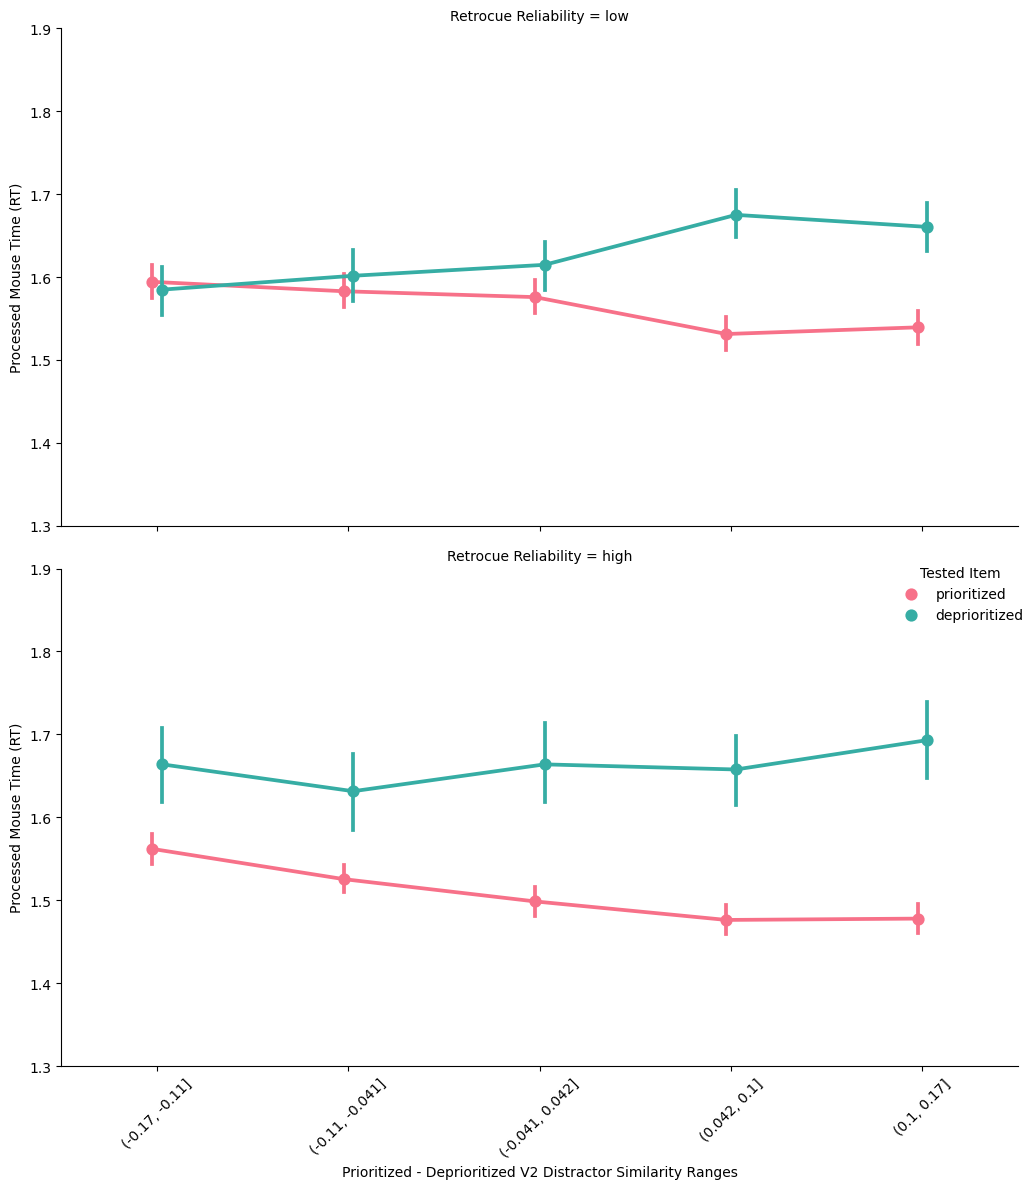

In [52]:
g = sns.catplot(
    x='Prioritized - Deprioritized V2 Distractor Similarity Ranges',
    y='analysis_rt',
    row='Retrocue Reliability',
    hue='Tested Item',  # Use 'row' instead of 'col'
    kind='point',
    row_order = ['low', 'high'],
    data=df_correct,
    dodge=True,
    height=6,
    aspect=1.5,
    palette=palette[::-1]  # Use the reversed color order
)
g.set(ylim=(1.3, 1.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    ax.set_xlabel('Prioritized - Deprioritized V2 Distractor Similarity Ranges')
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Set the y-axis label for all plots
g.set_axis_labels('Prioritized - Deprioritized V2 Distractor Similarity Ranges', 'Processed Mouse Time (RT)')

plt.tight_layout()
plt.show()

In [53]:
df['v2_prefers']

0          Prioritized
1          Prioritized
2          Prioritized
3        Deprioritized
4        Deprioritized
             ...      
40195      Prioritized
40196      Prioritized
40197    Deprioritized
40198      Prioritized
40199    Deprioritized
Name: v2_prefers, Length: 40200, dtype: object

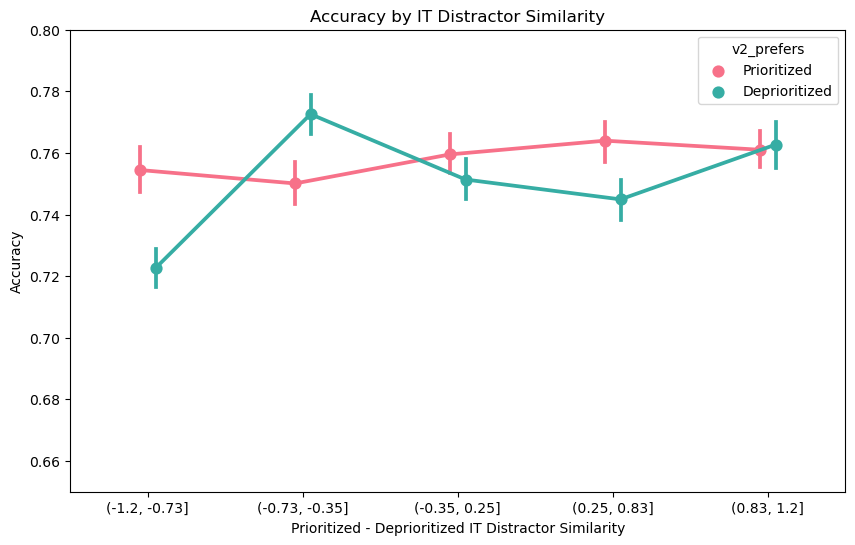

In [54]:
plt.figure(figsize=(10, 6))
sns.pointplot(
    x='IT_diff_binned',
    y='Accuracy',
    hue = 'v2_prefers',
    errorbar=('ci', 68),  # Updated error bar parameter
    dodge=0.1,
    palette=palette[::-1],  # Use the single-color palette
    data=df
)
plt.ylim(0.65, 0.8)
plt.ylabel('Accuracy')
plt.xlabel('Prioritized - Deprioritized IT Distractor Similarity')
plt.title('Accuracy by IT Distractor Similarity')
plt.show()

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/1380626430.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(46.88246527777777, 0.5, 'Accuracy')

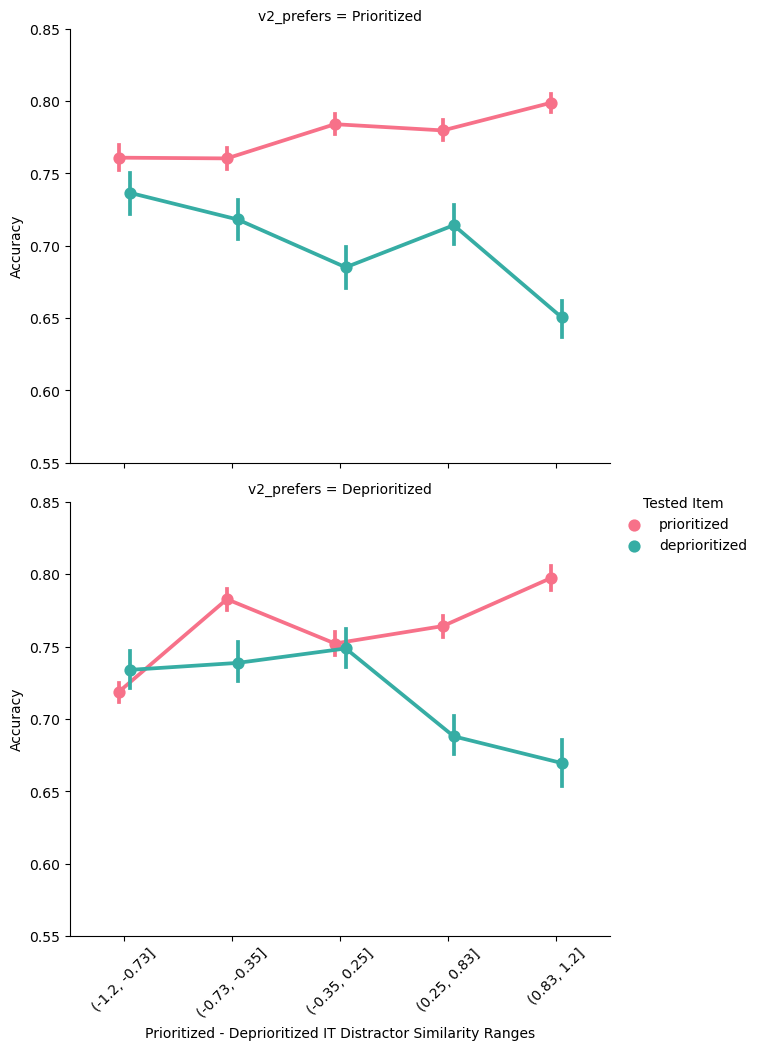

In [55]:
g = sns.catplot(
            x = 'Prioritized - Deprioritized IT Distractor Similarity Ranges',
            y = 'Accuracy',
            ci = 68,
            row = 'v2_prefers',
            hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = palette[::-1],  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')

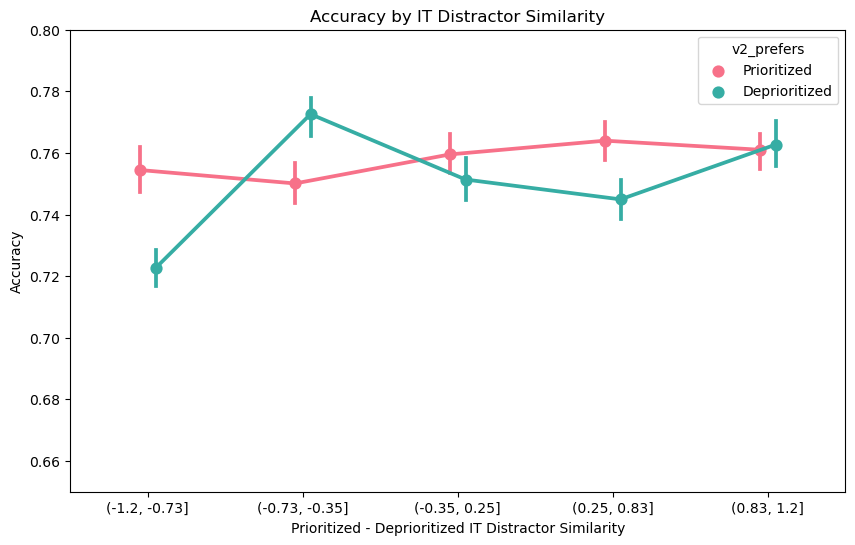

In [107]:
plt.figure(figsize=(10, 6))
sns.pointplot(
    x='IT_diff_binned',
    y='Accuracy',
    hue = 'v2_prefers', 
    errorbar=('ci', 68),  # Updated error bar parameter
    dodge=0.1,
    palette=palette[::-1],  # Use the single-color palette
    data=df
)
plt.ylim(0.65, 0.8)
plt.ylabel('Accuracy')
plt.xlabel('Prioritized - Deprioritized IT Distractor Similarity')
plt.title('Accuracy by IT Distractor Similarity')
plt.show()

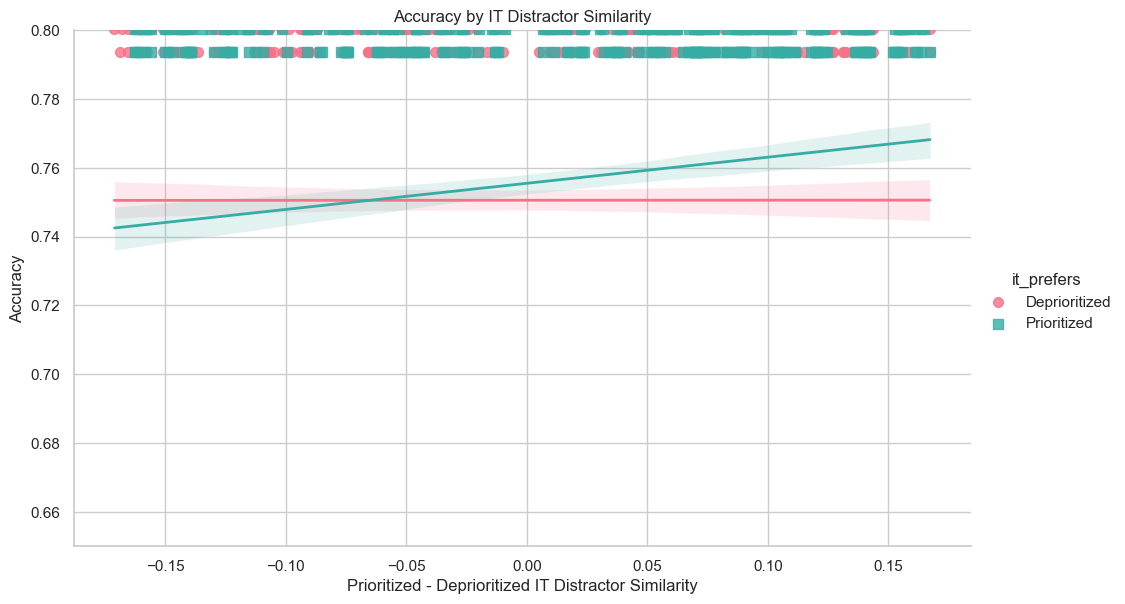

In [113]:
sns.set(style="whitegrid", rc={"figure.figsize": (10, 6)})

# Use lmplot to approximate the style of a pointplot
sns.lmplot(
    x='v2_sim_dis_diff',
    y='Accuracy',
    hue='it_prefers',
    data=df,
    ci=68,  # Confidence interval
    palette=palette[::-1],  # Reverse the palette
    scatter_kws={"s": 50},  # Adjust scatter plot size
    line_kws={"linewidth": 2},  # Adjust line width
    markers=["o", "s"],  # Different markers for groups
    height=6,  # Height of the plot
    aspect=1.67,  # Aspect ratio to mimic figsize
)

# Add axis labels and title
plt.ylim(0.65, 0.8)
plt.ylabel('Accuracy')
plt.xlabel('Prioritized - Deprioritized IT Distractor Similarity')
plt.title('Accuracy by IT Distractor Similarity')

plt.show()

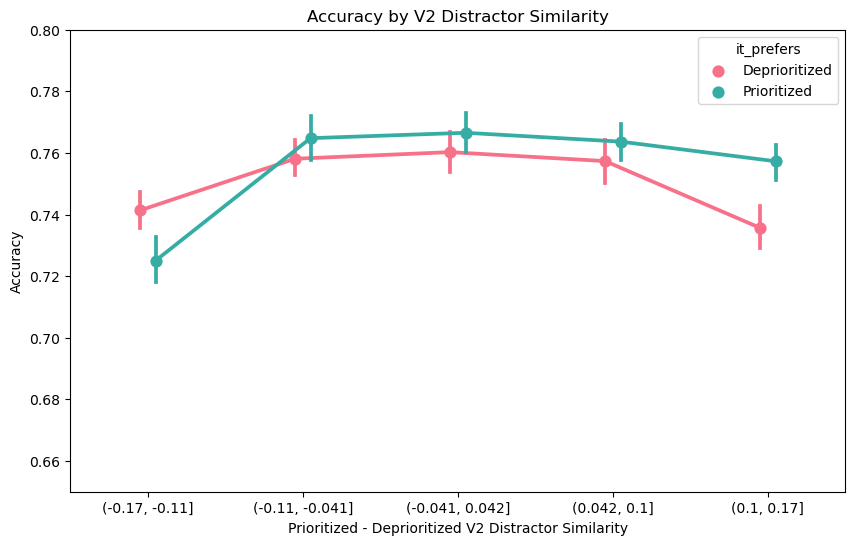

In [109]:
plt.figure(figsize=(10, 6))
sns.pointplot(
    x='V2_diff_binned',
    y='Accuracy',
    hue = 'it_prefers', 
    errorbar=('ci', 68),  # Updated error bar parameter
    dodge=0.1,
    palette=palette[::-1],  # Use the single-color palette
    data=df
)
plt.ylim(0.65, 0.8)
plt.ylabel('Accuracy')
plt.xlabel('Prioritized - Deprioritized V2 Distractor Similarity')
plt.title('Accuracy by V2 Distractor Similarity')
plt.show()

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/2852279418.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(44.99652777777777, 0.5, 'Accuracy')

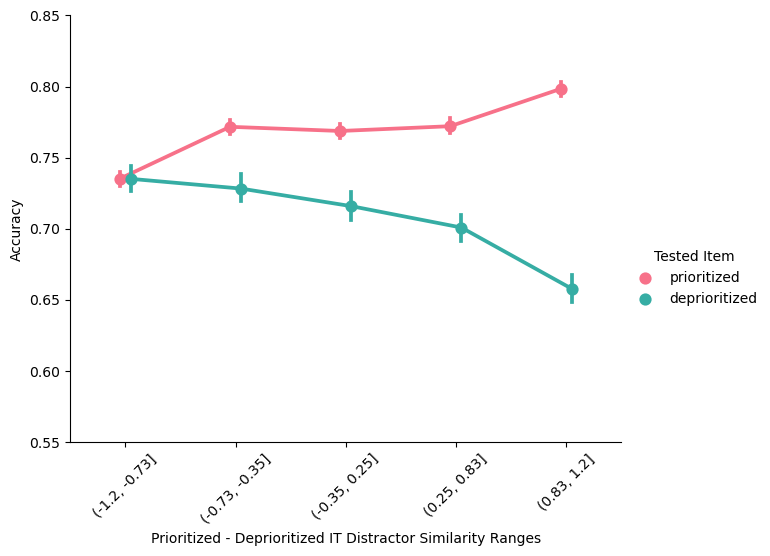

In [108]:
g = sns.catplot(
            x = 'Prioritized - Deprioritized IT Distractor Similarity Ranges',
            y = 'Accuracy',
            ci = 68,
#             row = 'v2_prefers',
            hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = palette[::-1],  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/790103852.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(45.877985517568845, 0.5, 'Accuracy')

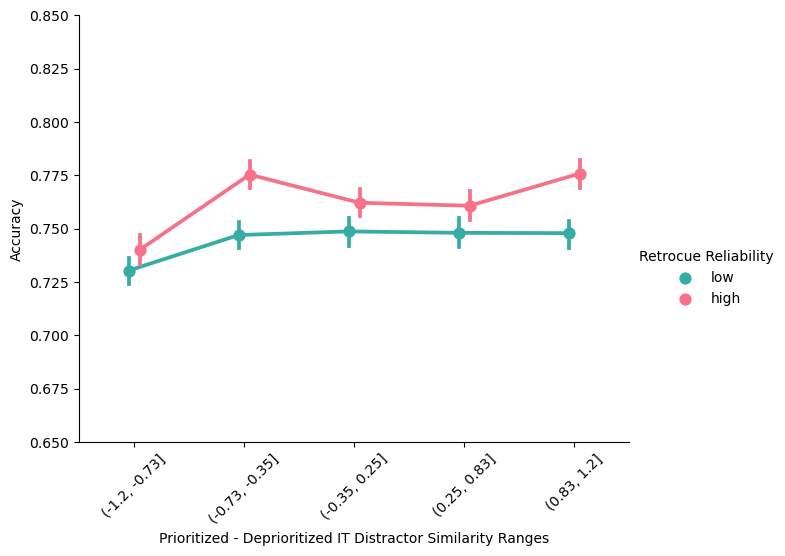

In [58]:
g = sns.catplot(
            x = 'Prioritized - Deprioritized IT Distractor Similarity Ranges',
            y = 'Accuracy',
            ci = 68,
            hue = 'Retrocue Reliability',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = palette,  # Reverse the color order
            data = df)
g.set(ylim=(0.65, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/400314580.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


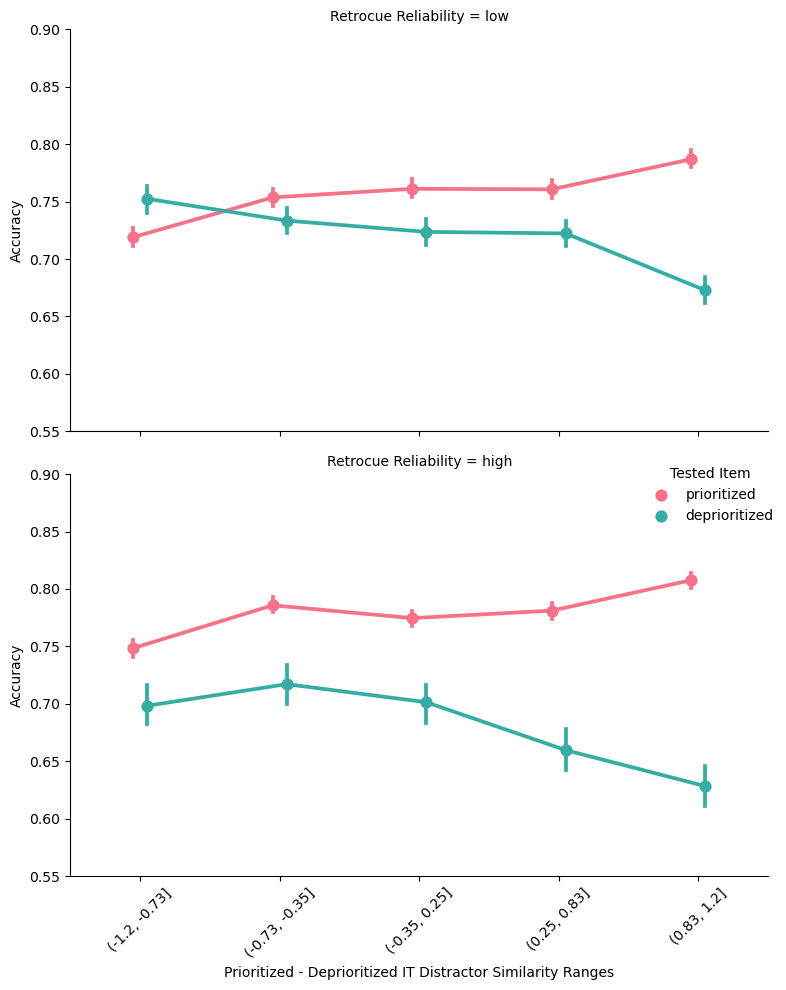

In [59]:


g = sns.catplot(
    x='Prioritized - Deprioritized IT Distractor Similarity Ranges',
    y='Accuracy',
    ci=68,
    hue='Tested Item',
    row='Retrocue Reliability',  # Use 'row' instead of 'col'
    aspect=1.3,
    row_order = ['low', 'high'],
    dodge=0.1,
    kind='point',
    palette=palette[::-1],  # Use the reversed color order
    data=df
)
g.set(ylim=(0.55, 0.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

g.set_axis_labels("Prioritized - Deprioritized IT Distractor Similarity Ranges", "Accuracy")
plt.tight_layout()
plt.show()

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/857288995.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


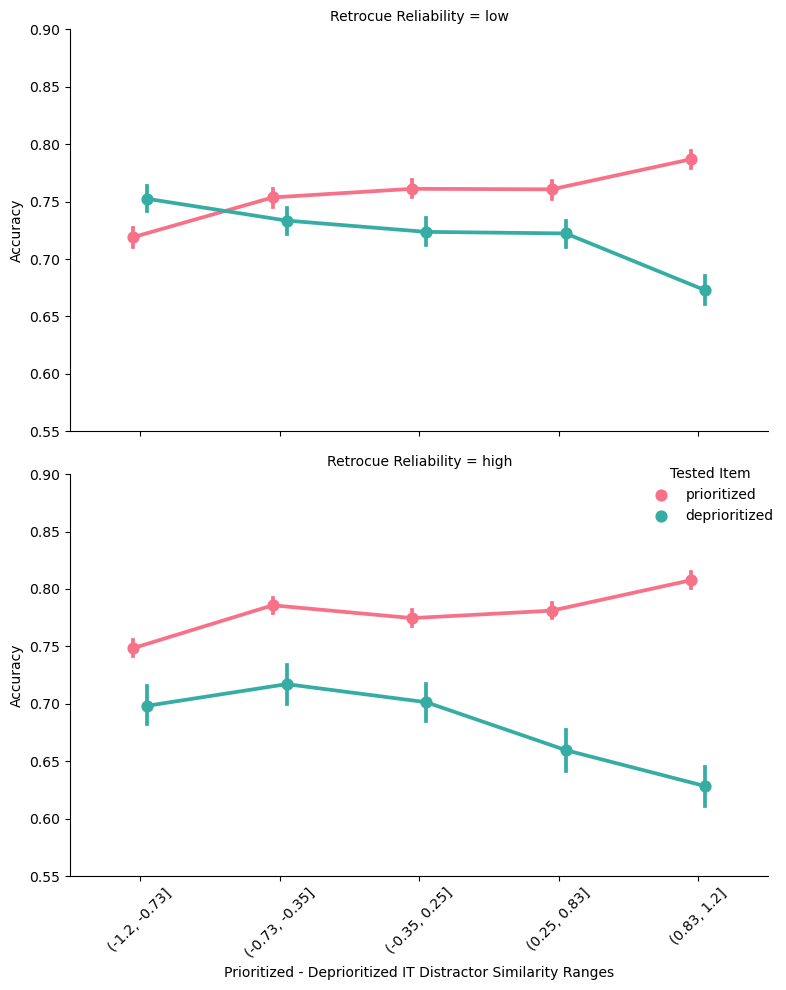

In [60]:

g = sns.catplot(
    x='Prioritized - Deprioritized IT Distractor Similarity Ranges',
    y='Accuracy',
    ci=68,
    hue='Tested Item',
    row='Retrocue Reliability',  # Use 'row' instead of 'col'
    aspect=1.3,
#     row_order = ['low', 'high'],
    dodge=0.1,
    kind='point',
    palette=palette[::-1],  # Use the reversed color order
    data=df
)
g.set(ylim=(0.55, 0.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

g.set_axis_labels("Prioritized - Deprioritized IT Distractor Similarity Ranges", "Accuracy")
plt.tight_layout()
plt.show()

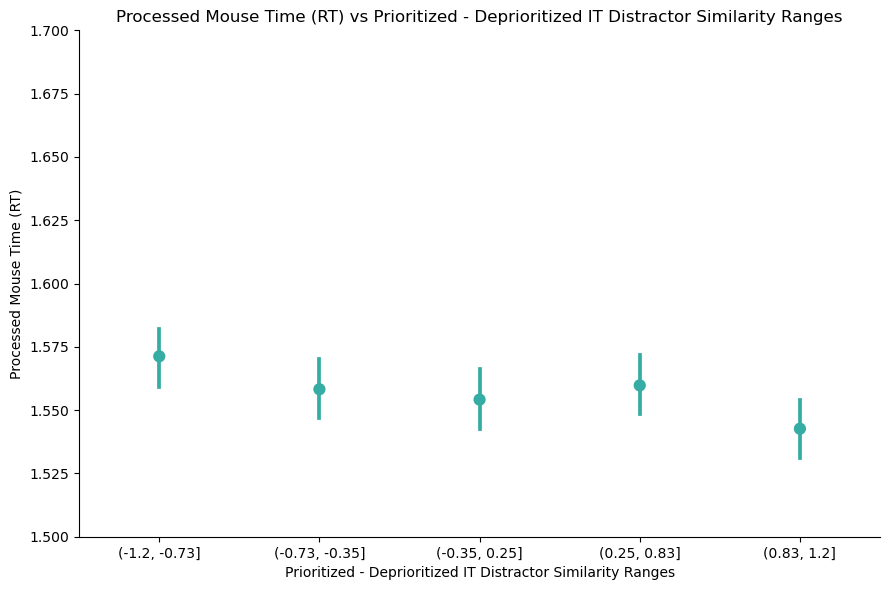

In [61]:
g = sns.catplot(x='Prioritized - Deprioritized IT Distractor Similarity Ranges', y='analysis_rt', 
#                 hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            # order=['Least Similar', ' ', ' ', ' ', 'Most Similar'],  # Specify the order of the categories
            palette = single_color_palette  # Reverse the color order
)
g.set(ylim=(1.5, 1.7))

plt.xlabel('Prioritized - Deprioritized IT Distractor Similarity Ranges')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs Prioritized - Deprioritized IT Distractor Similarity Ranges')
plt.tight_layout()
plt.show()

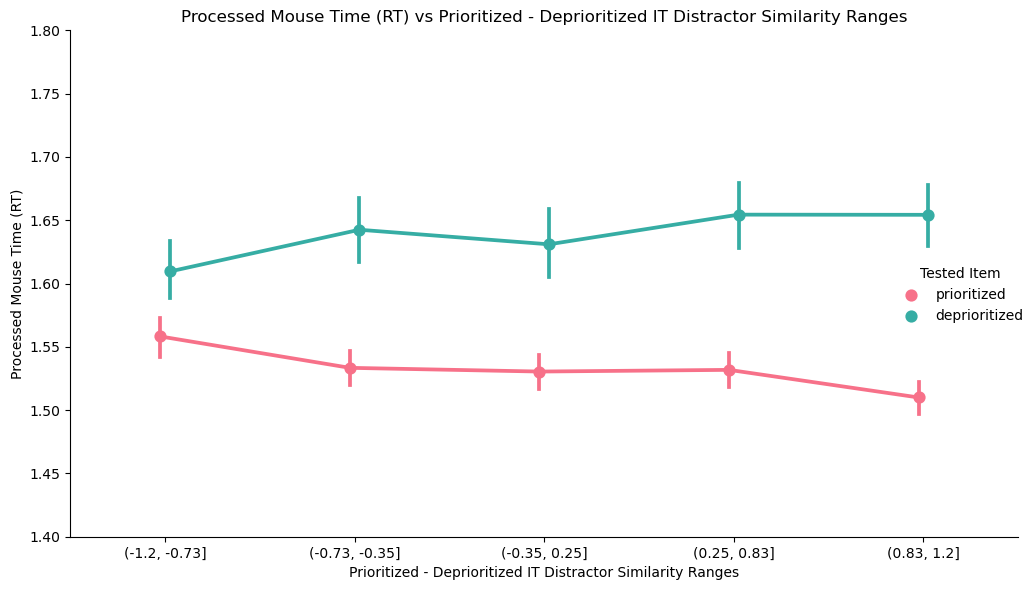

In [62]:
g = sns.catplot(x='Prioritized - Deprioritized IT Distractor Similarity Ranges', y='analysis_rt', 
                hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette[::-1]  # Reverse the color order
)
g.set(ylim=(1.4, 1.8))

plt.xlabel('Prioritized - Deprioritized IT Distractor Similarity Ranges')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs Prioritized - Deprioritized IT Distractor Similarity Ranges')
plt.tight_layout()
plt.show()

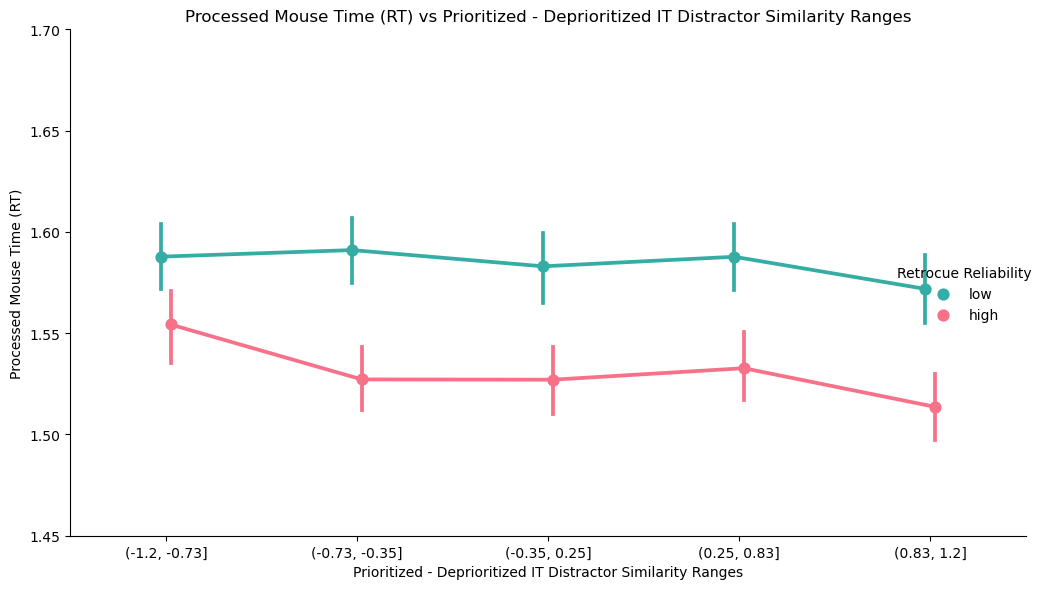

In [63]:
g = sns.catplot(x='Prioritized - Deprioritized IT Distractor Similarity Ranges', y='analysis_rt', 
                hue='Retrocue Reliability', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette  # Reverse the color order
)
g.set(ylim=(1.45, 1.7))

plt.xlabel('Prioritized - Deprioritized IT Distractor Similarity Ranges')
plt.ylabel('Processed Mouse Time (RT)')
plt.title('Processed Mouse Time (RT) vs Prioritized - Deprioritized IT Distractor Similarity Ranges')
plt.tight_layout()
plt.show()

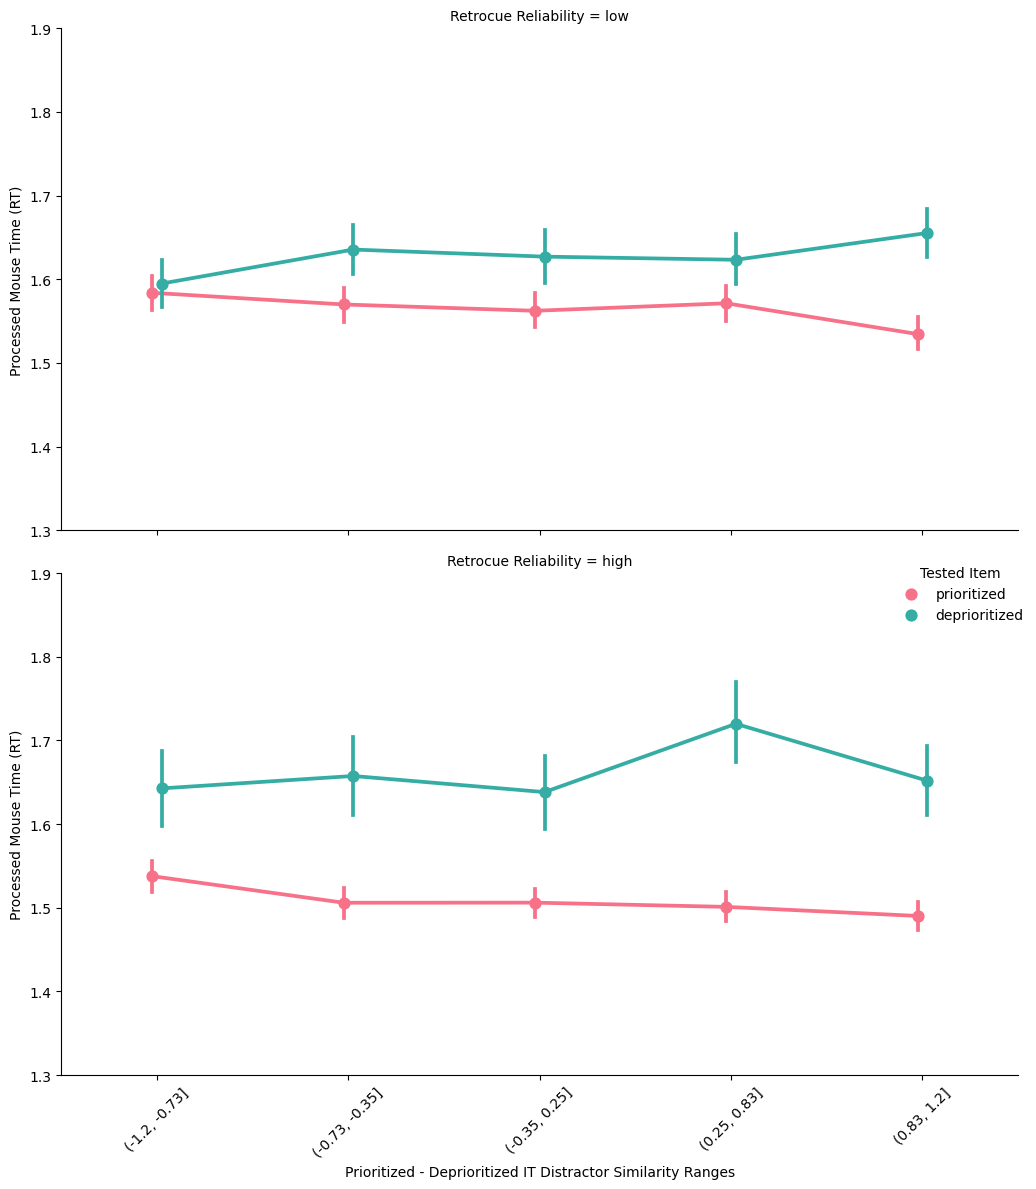

In [64]:
g = sns.catplot(
    x='Prioritized - Deprioritized IT Distractor Similarity Ranges',
    y='analysis_rt',
    row='Retrocue Reliability',
    hue='Tested Item',  # Use 'row' instead of 'col'
    kind='point',
    row_order = ['low', 'high'],
    data=df_correct,
    dodge=True,
    height=6,
    aspect=1.5,
    palette=palette[::-1] # Use the reversed color order
)
g.set(ylim=(1.3, 1.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    ax.set_xlabel('Prioritized - Deprioritized IT Distractor Similarity Ranges')
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Set the y-axis label for all plots
g.set_axis_labels('Prioritized - Deprioritized IT Distractor Similarity Ranges', 'Processed Mouse Time (RT)')

plt.tight_layout()
plt.show()

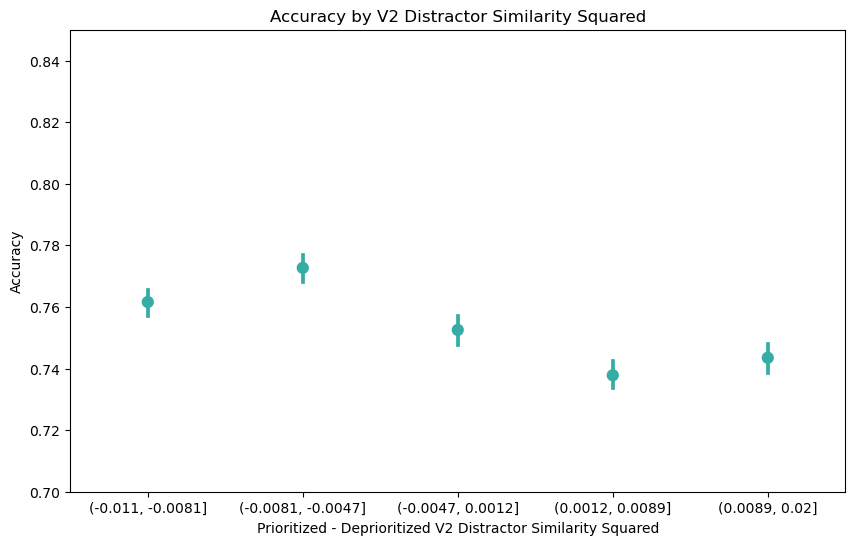

In [65]:
plt.figure(figsize=(10, 6))
sns.pointplot(
    x='V2_diff_binned_sq',
    y='Accuracy',
    errorbar=('ci', 68),  # Updated error bar parameter
    dodge=0.1,
    palette=single_color_palette,  # Use the single-color palette
    data=df
)
plt.ylim(0.7, 0.85)
plt.ylabel('Accuracy')
plt.xlabel('Prioritized - Deprioritized V2 Distractor Similarity Squared')
plt.title('Accuracy by V2 Distractor Similarity Squared')
plt.show()




/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/3699410078.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(44.99652777777777, 0.5, 'Accuracy')

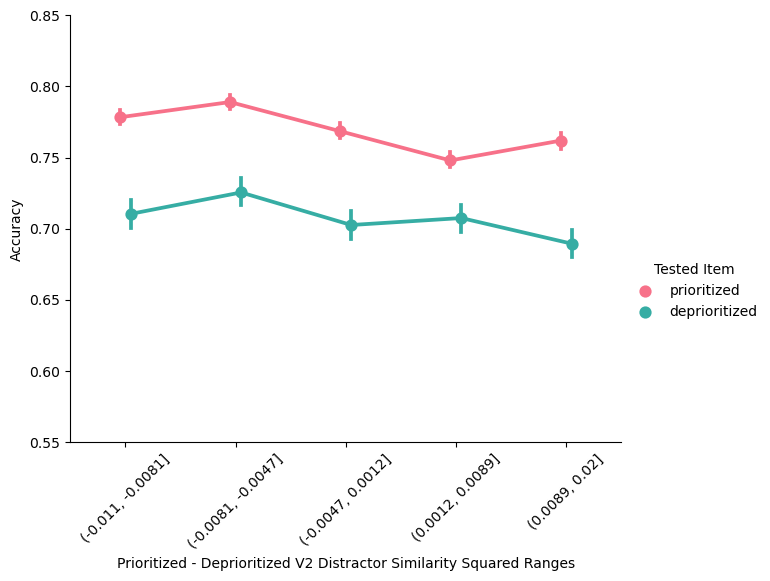

In [66]:

g = sns.catplot(
            x = 'Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges',
            y = 'Accuracy',
            ci = 68,
            hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = sns.color_palette("husl", n_colors=2),  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')



/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/3775300540.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(45.877985517568845, 0.5, 'Accuracy')

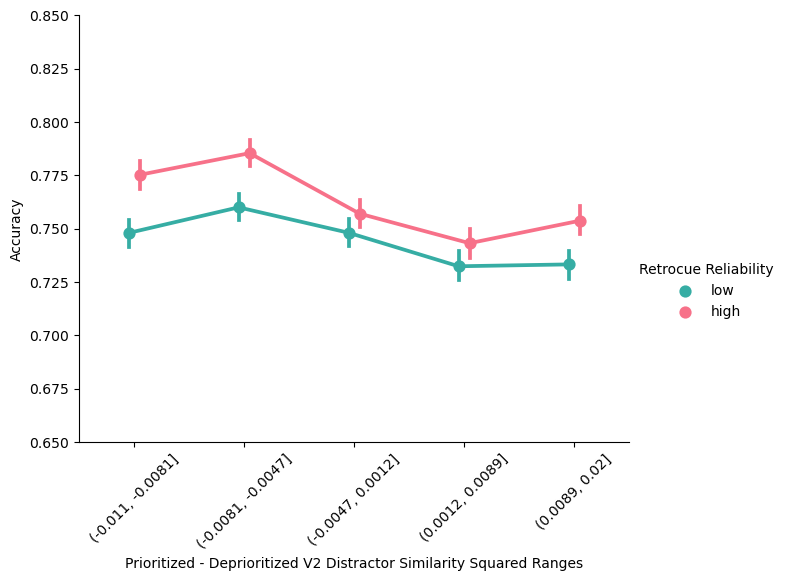

In [67]:

g = sns.catplot(
            x = 'Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges',
            y = 'Accuracy',
            ci = 68,
            hue = 'Retrocue Reliability',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = palette,  # Reverse the color order
            data = df)
g.set(ylim=(0.65, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/2709325249.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


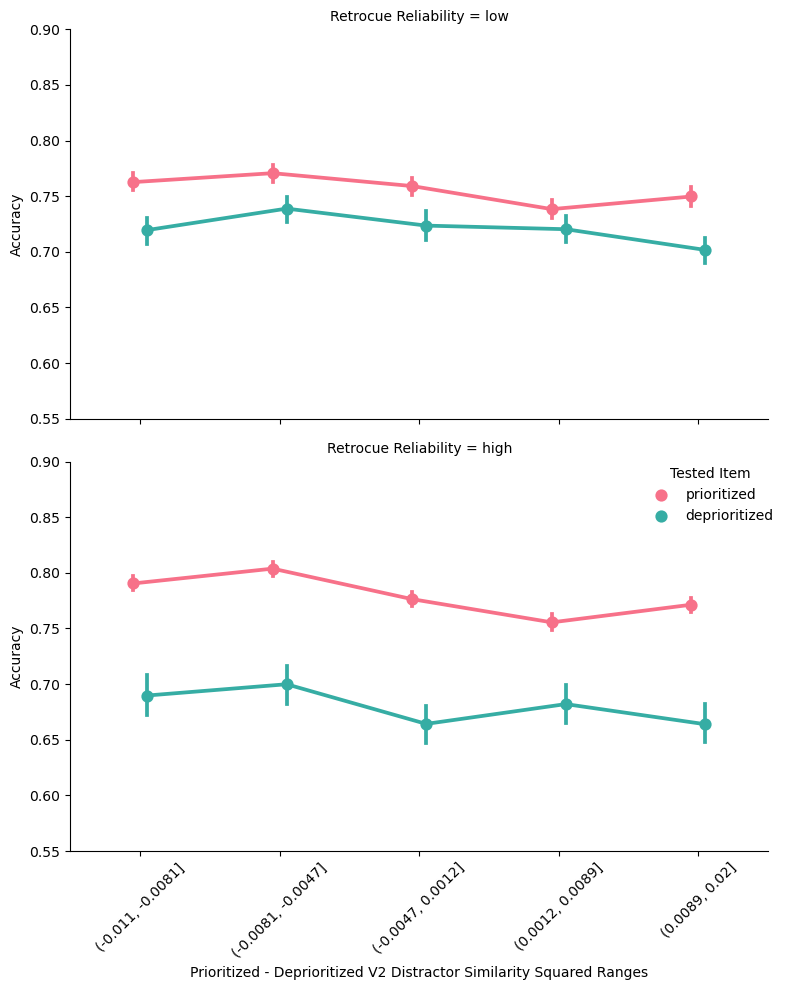

In [68]:


g = sns.catplot(
    x='Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges',
    y='Accuracy',
    ci=68,
    hue='Tested Item',
    row='Retrocue Reliability',  # Use 'row' instead of 'col'
    aspect=1.3,
    row_order = ['low', 'high'],
    dodge=0.1,
    kind='point',
    palette=palette[::-1],  # Use the reversed color order
    data=df
)
g.set(ylim=(0.55, 0.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

g.set_axis_labels("Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges", "Accuracy")
plt.tight_layout()
plt.show()

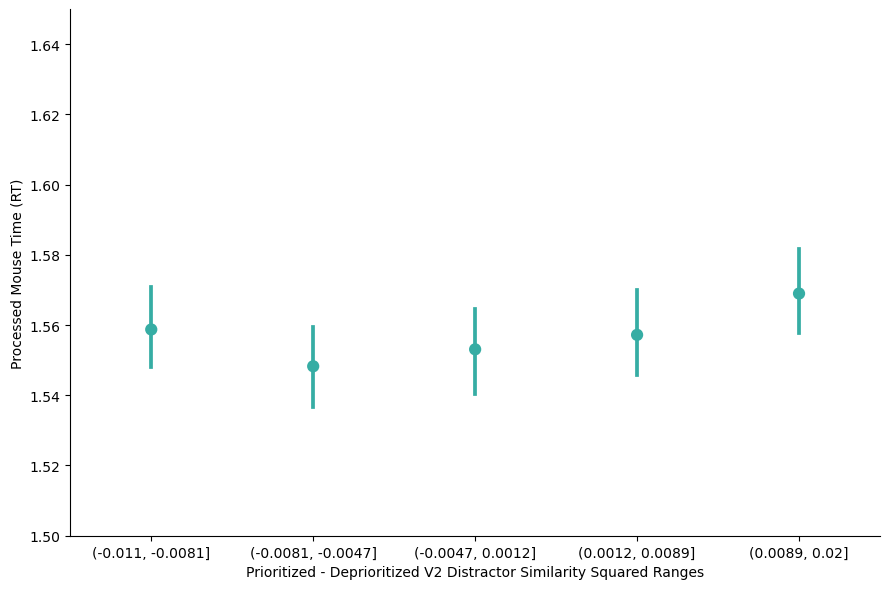

In [69]:
g = sns.catplot(x='Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges', y='analysis_rt', 
#                 hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            # order=['Least Similar', ' ', ' ', ' ', 'Most Similar'],  # Specify the order of the categories
            palette = single_color_palette  # Reverse the color order
)
g.set(ylim=(1.5, 1.65))

plt.xlabel('Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges')
plt.ylabel('Processed Mouse Time (RT)')
# plt.title('Processed Mouse Time (RT) vs V2 Distractor Similarity\nSquared Ranges')
plt.tight_layout()
plt.show()



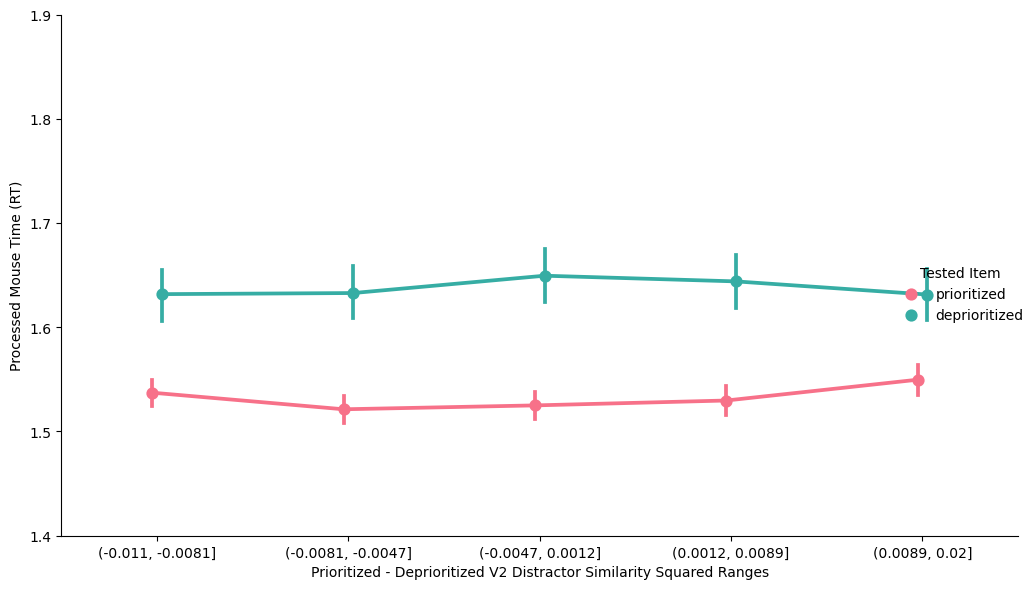

In [70]:
g = sns.catplot(x='Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges', y='analysis_rt', 
                hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette[::-1]  # Reverse the color order
)
g.set(ylim=(1.4, 1.9))

plt.xlabel('Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges')
plt.ylabel('Processed Mouse Time (RT)')
# plt.title('Processed Mouse Time (RT) vs V2 Distractor Similarity\nto Prioritized Item')
plt.tight_layout()
plt.show()



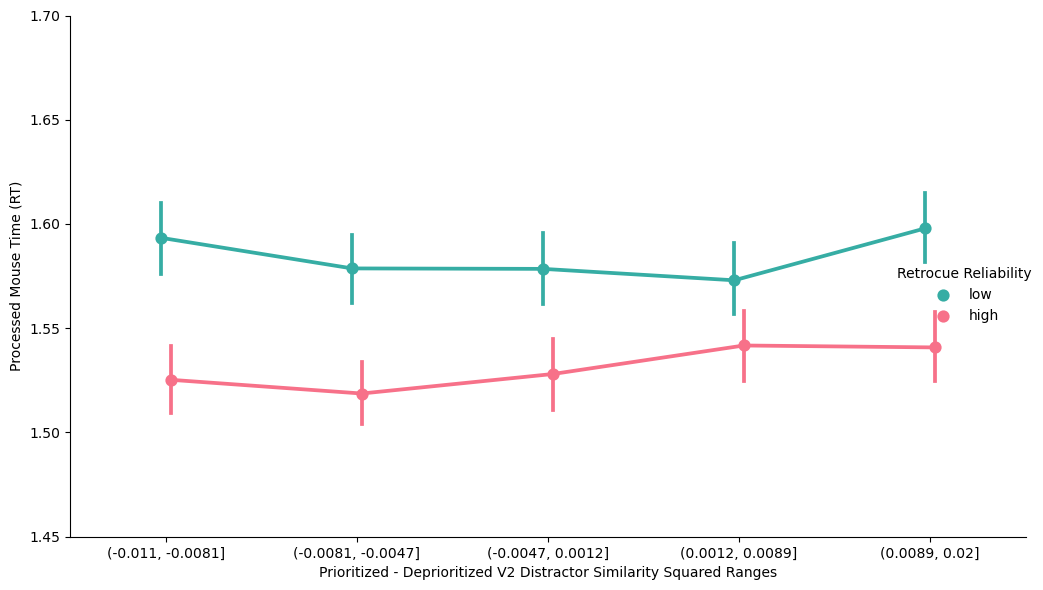

In [71]:
g = sns.catplot(x='Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges', y='analysis_rt', 
                hue='Retrocue Reliability', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette  # Reverse the color order
)
g.set(ylim=(1.45, 1.7))

plt.xlabel('Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges')
plt.ylabel('Processed Mouse Time (RT)')
# plt.title('Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges')
plt.tight_layout()
plt.show()



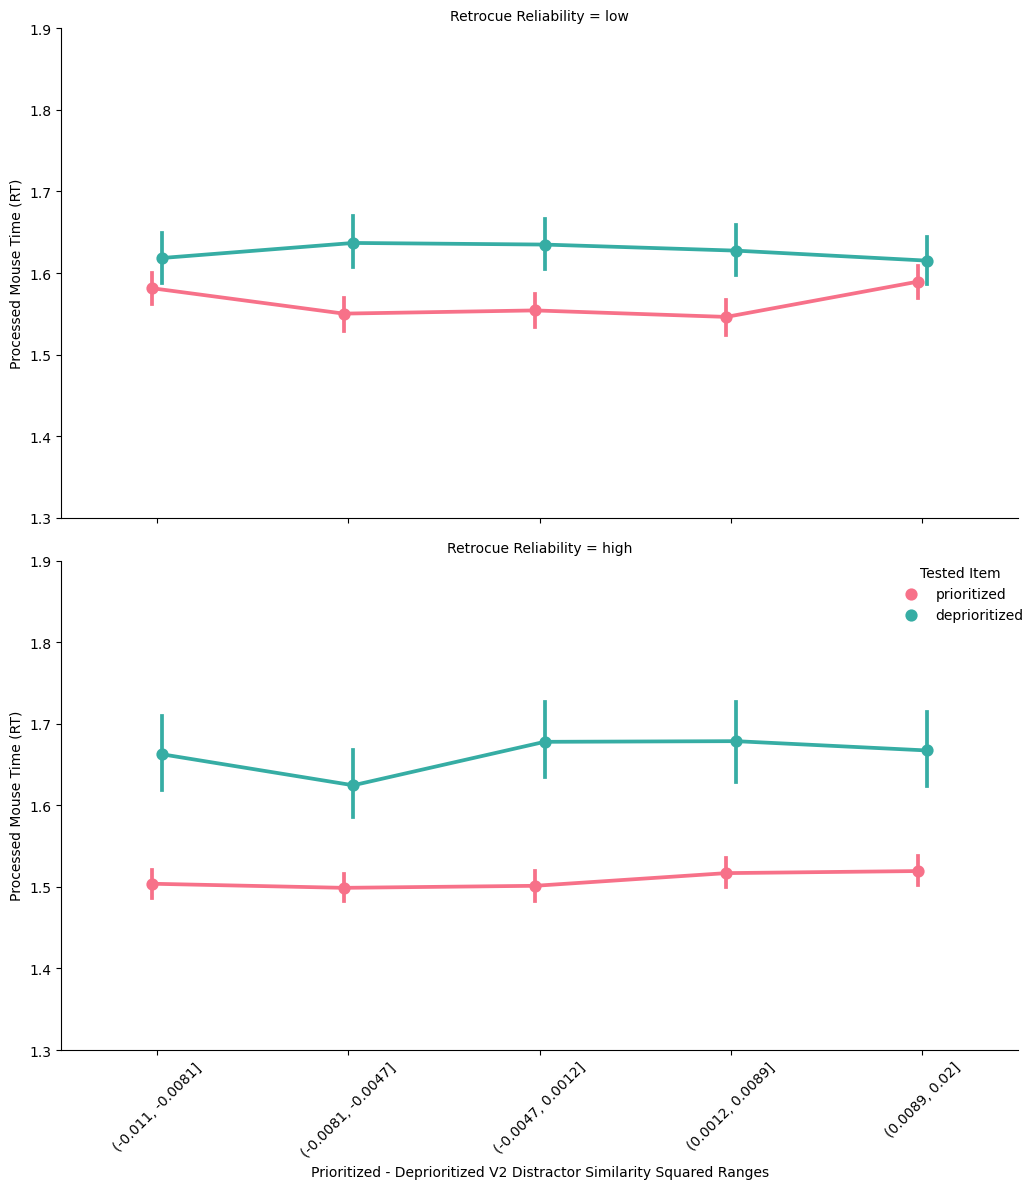

In [72]:
g = sns.catplot(
    x='Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges',
    y='analysis_rt',
    row='Retrocue Reliability',
    hue='Tested Item',  # Use 'row' instead of 'col'
    kind='point',
    row_order = ['low', 'high'], 
    data=df_correct,
    dodge=True,
    height=6,
    aspect=1.5,
    palette=palette[::-1]  # Use the reversed color order
)
g.set(ylim=(1.3, 1.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    ax.set_xlabel('Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges')
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Set the y-axis label for all plots
g.set_axis_labels('Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges', 'Processed Mouse Time (RT)')

plt.tight_layout()
plt.show()



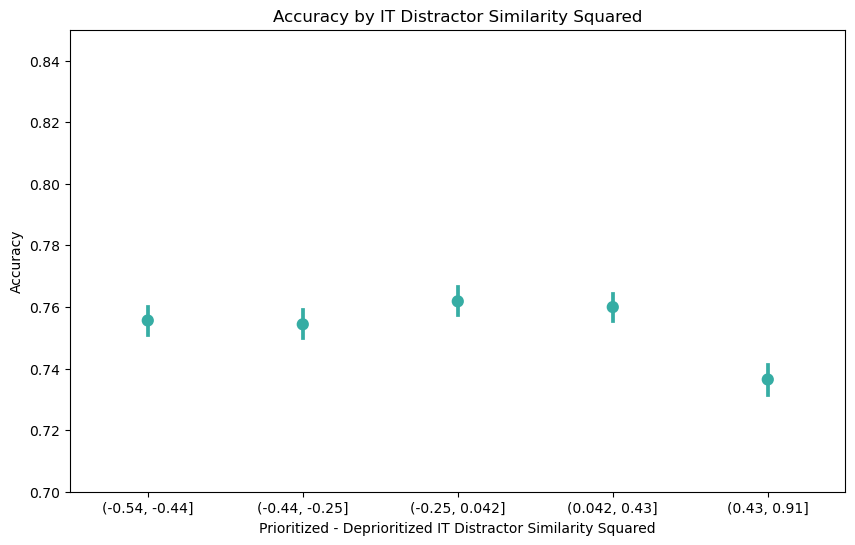

In [73]:
plt.figure(figsize=(10, 6))
sns.pointplot(
    x='IT_diff_binned_sq',
    y='Accuracy',
    errorbar=('ci', 68),  # Updated error bar parameter
    dodge=0.1,
    palette=single_color_palette,  # Use the single-color palette
    data=df
)
plt.ylim(0.7, 0.85)
plt.ylabel('Accuracy')
plt.xlabel('Prioritized - Deprioritized IT Distractor Similarity Squared')
plt.title('Accuracy by IT Distractor Similarity Squared')
plt.show()


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/3125865.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(44.99652777777777, 0.5, 'Accuracy')

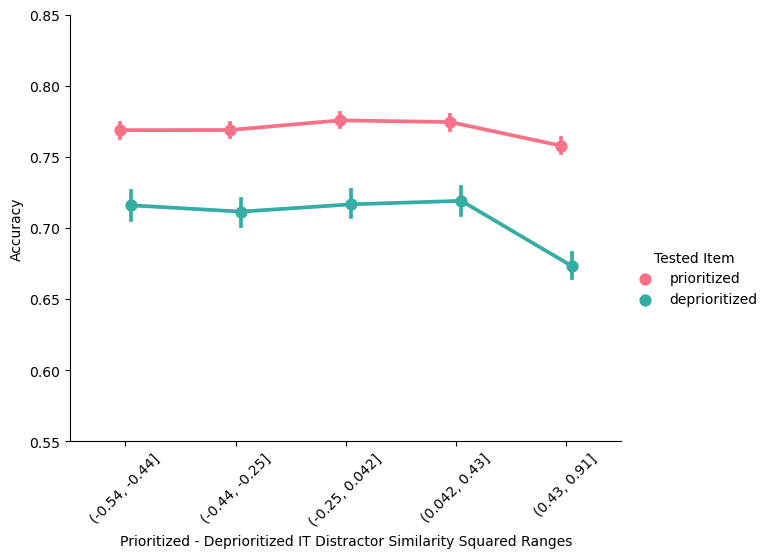

In [74]:


g = sns.catplot(
            x = 'Prioritized - Deprioritized IT Distractor Similarity Squared Ranges',
            y = 'Accuracy',
            ci = 68,
            hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = sns.color_palette("husl", n_colors=2),  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')



/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/103419771.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(45.877985517568845, 0.5, 'Accuracy')

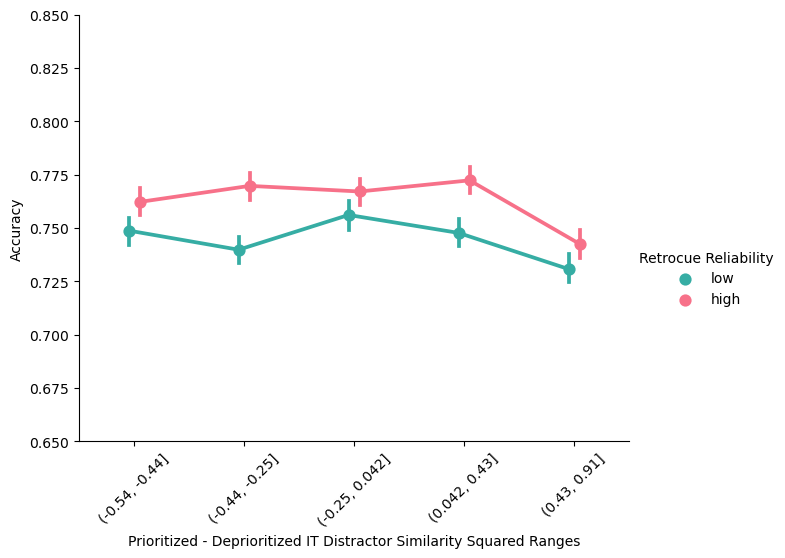

In [75]:

g = sns.catplot(
            x = 'Prioritized - Deprioritized IT Distractor Similarity Squared Ranges',
            y = 'Accuracy',
            ci = 68,
            hue = 'Retrocue Reliability',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = palette,  # Reverse the color order
            data = df)
g.set(ylim=(0.65, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')



/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/603937276.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


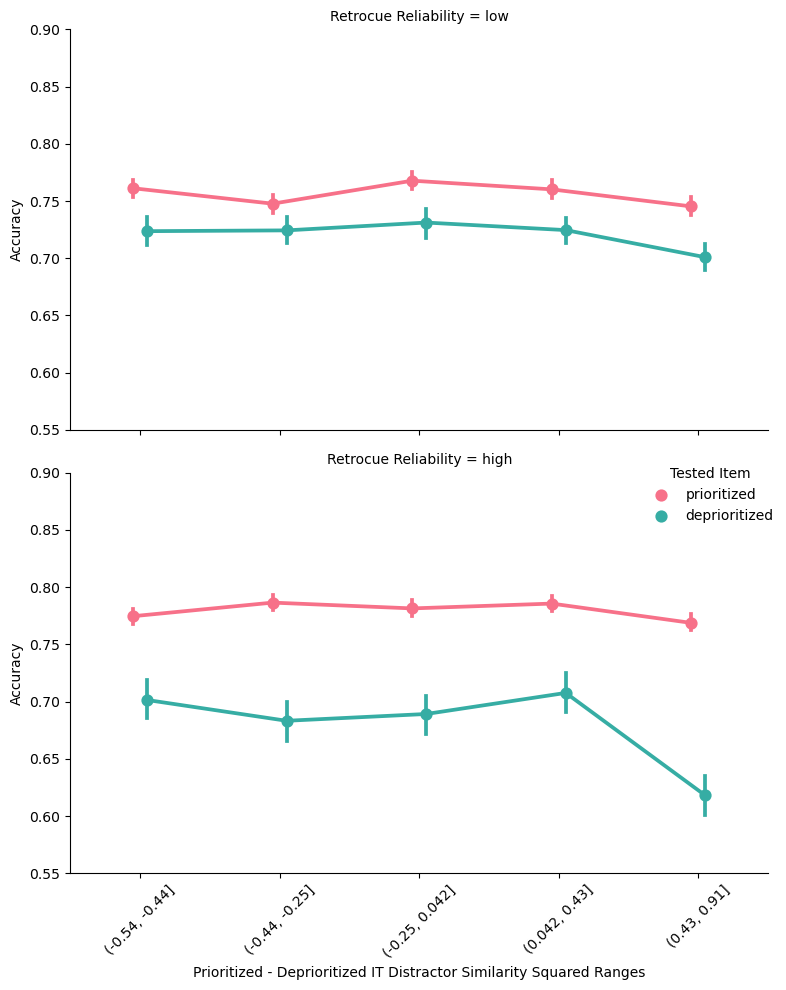

In [76]:

g = sns.catplot(
    x='Prioritized - Deprioritized IT Distractor Similarity Squared Ranges',
    y='Accuracy',
    ci=68,
    hue='Tested Item',
    row='Retrocue Reliability',  # Use 'row' instead of 'col'
    aspect=1.3,
    row_order = ['low', 'high'],
    dodge=0.1,
    kind='point',
    palette=palette[::-1],  # Use the reversed color order
    data=df
)
g.set(ylim=(0.55, 0.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

g.set_axis_labels("Prioritized - Deprioritized IT Distractor Similarity Squared Ranges", "Accuracy")
plt.tight_layout()
plt.show()

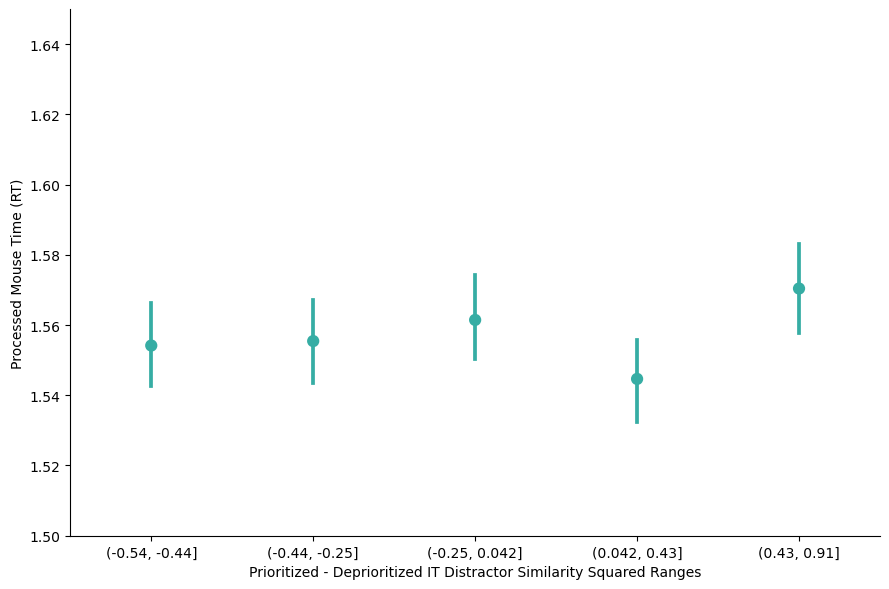

In [77]:
g = sns.catplot(x='Prioritized - Deprioritized IT Distractor Similarity Squared Ranges', y='analysis_rt', 
#                 hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            # order=['Least Similar', ' ', ' ', ' ', 'Most Similar'],  # Specify the order of the categories
            palette = single_color_palette  # Reverse the color order
)
g.set(ylim=(1.5, 1.65))

plt.xlabel('Prioritized - Deprioritized IT Distractor Similarity Squared Ranges')
plt.ylabel('Processed Mouse Time (RT)')
# plt.title('Processed Mouse Time (RT) vs V2 Distractor Similarity\nSquared Ranges')
plt.tight_layout()
plt.show()


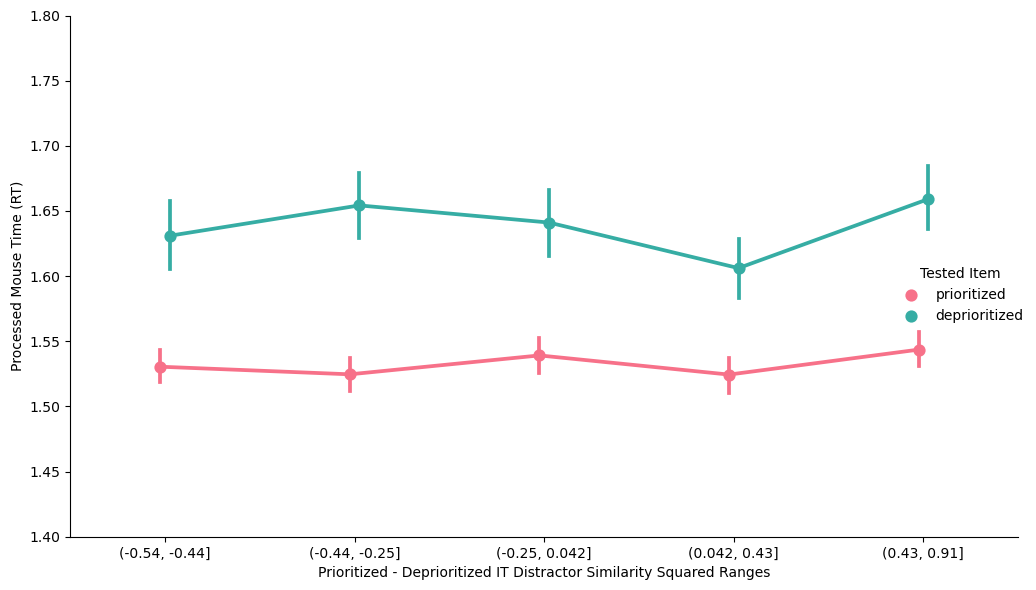

In [78]:

g = sns.catplot(x='Prioritized - Deprioritized IT Distractor Similarity Squared Ranges', y='analysis_rt', 
                hue='Tested Item', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette[::-1]  # Reverse the color order
)
g.set(ylim=(1.4, 1.8))

plt.xlabel('Prioritized - Deprioritized IT Distractor Similarity Squared Ranges')
plt.ylabel('Processed Mouse Time (RT)')
# plt.title('Processed Mouse Time (RT) vs V2 Distractor Similarity\nto Prioritized Item')
plt.tight_layout()
plt.show()



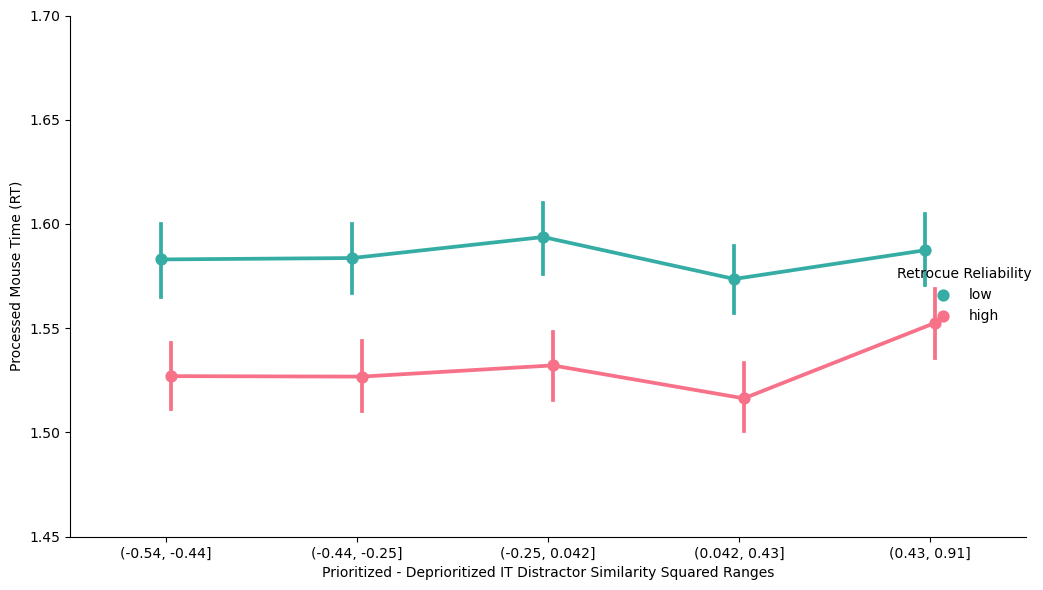

In [79]:

g = sns.catplot(x='Prioritized - Deprioritized IT Distractor Similarity Squared Ranges', y='analysis_rt', 
                hue='Retrocue Reliability', 
            kind='point', data=df_correct, dodge=True, height=6, aspect=1.5, 
            palette = palette  # Reverse the color order
)
g.set(ylim=(1.45, 1.7))

plt.xlabel('Prioritized - Deprioritized IT Distractor Similarity Squared Ranges')
plt.ylabel('Processed Mouse Time (RT)')
# plt.title('Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges')
plt.tight_layout()
plt.show()



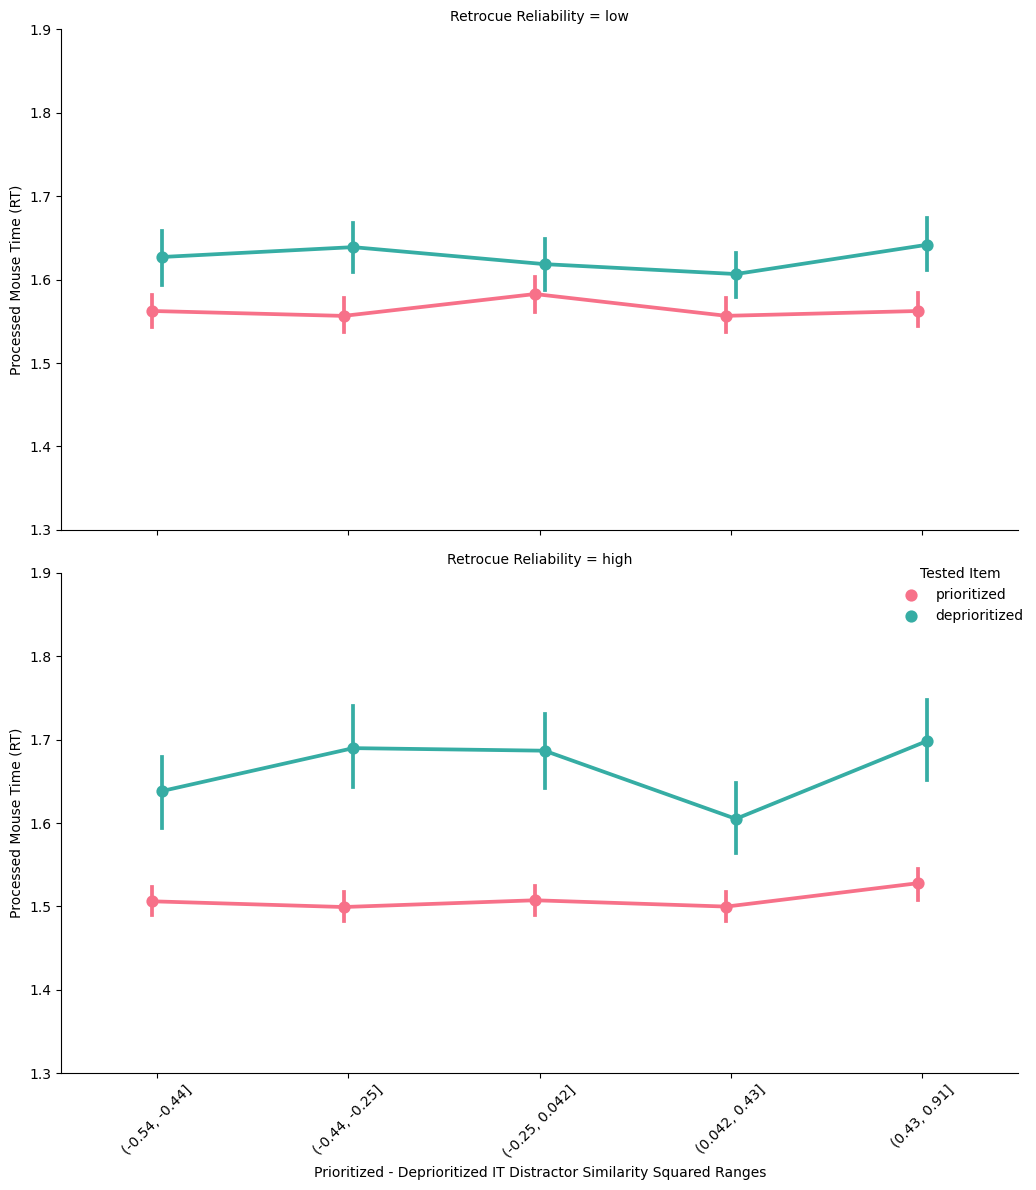

In [80]:
g = sns.catplot(
    x='Prioritized - Deprioritized IT Distractor Similarity Squared Ranges',
    y='analysis_rt',
    row='Retrocue Reliability',
    hue='Tested Item',  # Use 'row' instead of 'col'
    kind='point',
    row_order = ['low', 'high'],
    data=df_correct,
    dodge=True,
    height=6,
    aspect=1.5,
    palette=palette[::-1]  # Use the reversed color order
)
g.set(ylim=(1.3, 1.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    ax.set_xlabel('Prioritized - Deprioritized IT Distractor Similarity Squared Ranges')
    for label in ax.get_xticklabels():
        label.set_rotation(45)

# Set the y-axis label for all plots
g.set_axis_labels('Prioritized - Deprioritized IT Distractor Similarity Squared Ranges', 'Processed Mouse Time (RT)')

plt.tight_layout()
plt.show()


In [81]:
len(set(df['participant']))

134

In [82]:
df.to_csv('old_dataframe.csv', index=False)  # Set index=False to avoid saving row indices


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/3730263845.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(45.21367521367522, 0.5, 'Accuracy')

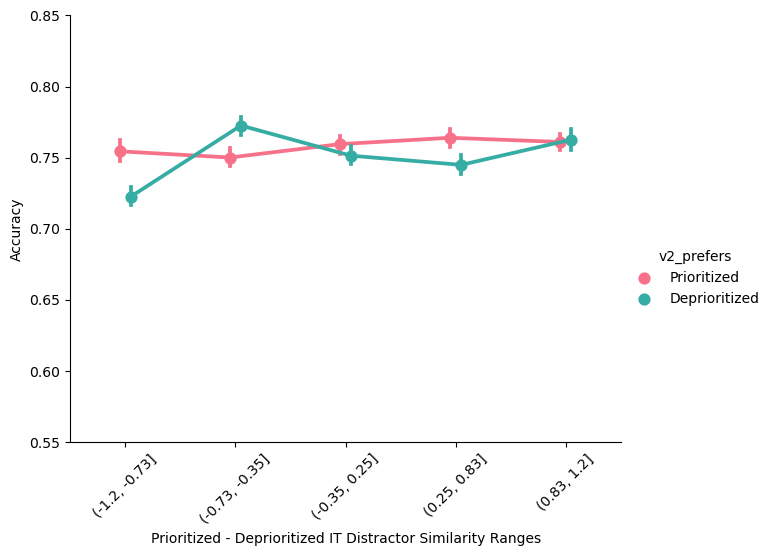

In [83]:
g = sns.catplot(
            x = 'Prioritized - Deprioritized IT Distractor Similarity Ranges',
            y = 'Accuracy',
            ci = 68,
            hue = 'v2_prefers',
#             hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = palette[::-1],  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/1380626430.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(46.88246527777777, 0.5, 'Accuracy')

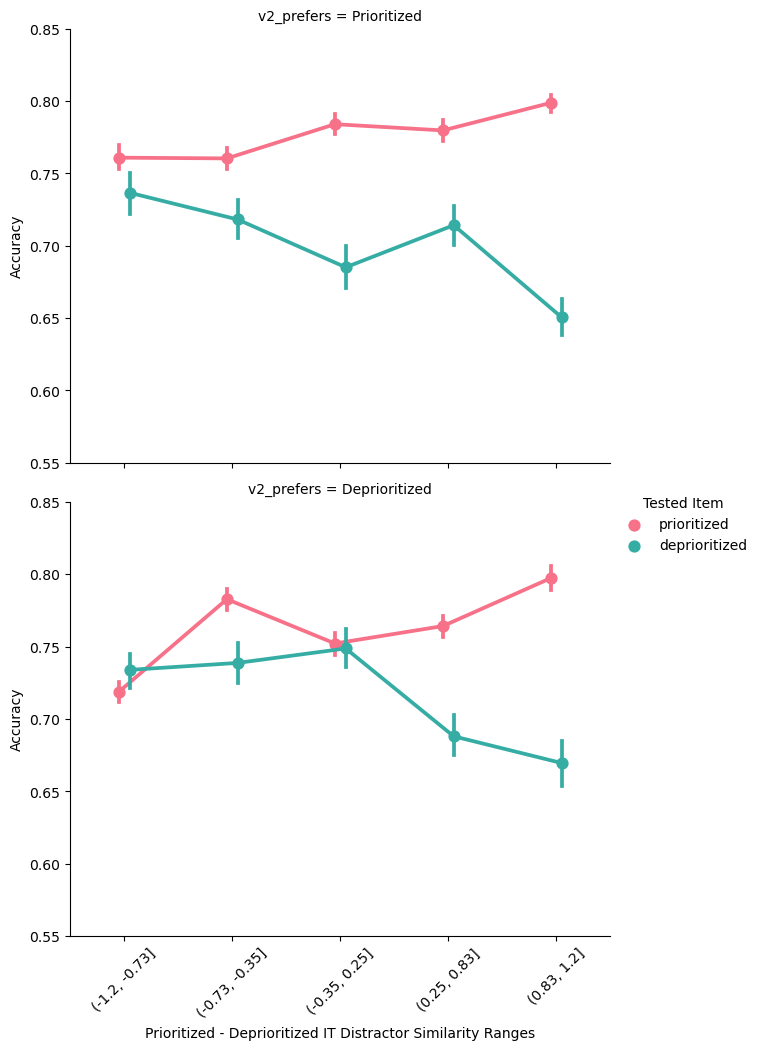

In [84]:
g = sns.catplot(
            x = 'Prioritized - Deprioritized IT Distractor Similarity Ranges',
            y = 'Accuracy',
            ci = 68,
            row = 'v2_prefers',
            hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = palette[::-1],  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/1772617952.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(45.21367521367522, 0.5, 'Accuracy')

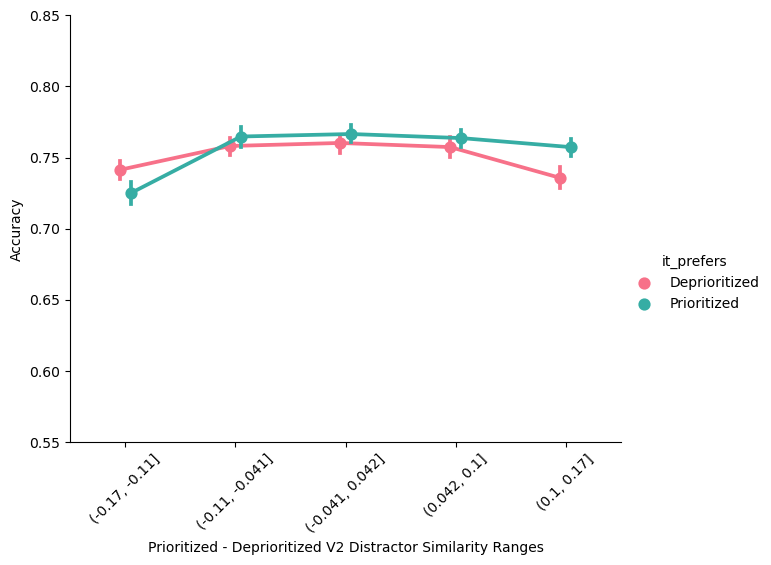

In [85]:
g = sns.catplot(
            x = 'Prioritized - Deprioritized V2 Distractor Similarity Ranges',
            y = 'Accuracy',
            ci = 68,
            hue = 'it_prefers',
#             hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = palette[::-1],  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/2612231446.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


Text(44.99652777777777, 0.5, 'Accuracy')

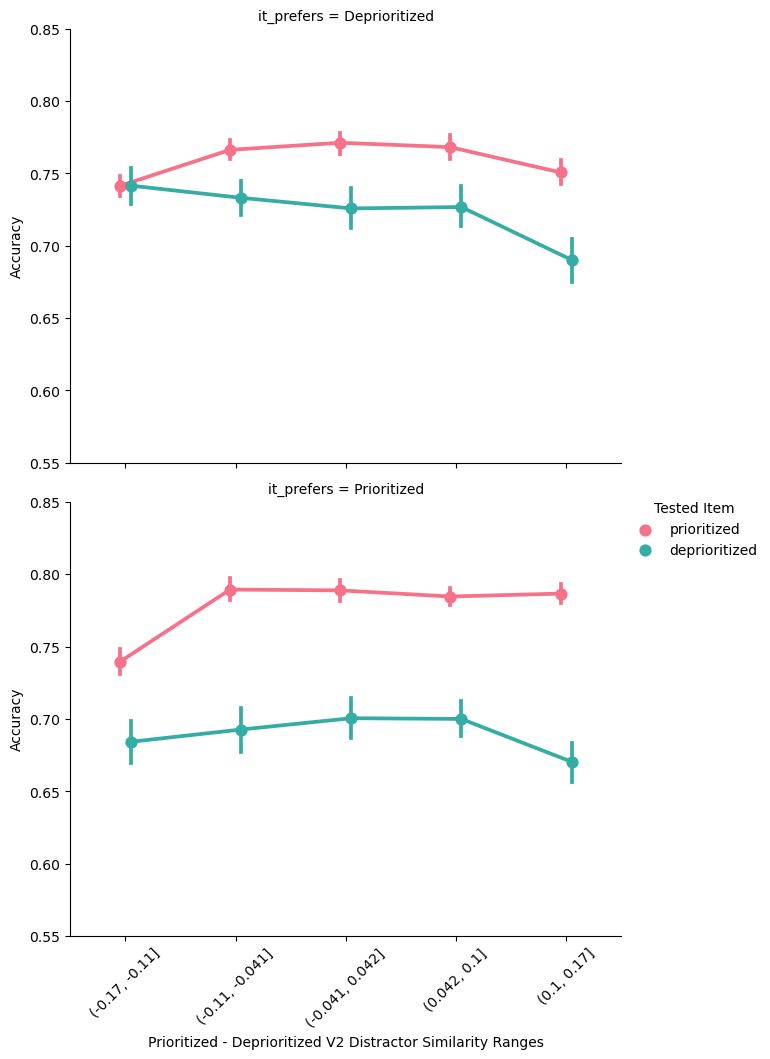

In [86]:
g = sns.catplot(
            x = 'Prioritized - Deprioritized V2 Distractor Similarity Ranges',
            y = 'Accuracy',
            ci = 68,
            row = 'it_prefers',
            hue = 'Tested Item',
            # col = 'Retrocue Reliability',
            aspect = 1.3,
            dodge = 0.1,
            kind = 'point',
            
            palette = palette[::-1],  # Reverse the color order
            data = df)
g.set(ylim=(0.55, 0.85))
plt.xticks(rotation=45)

plt.ylabel('Accuracy')

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/2051032623.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


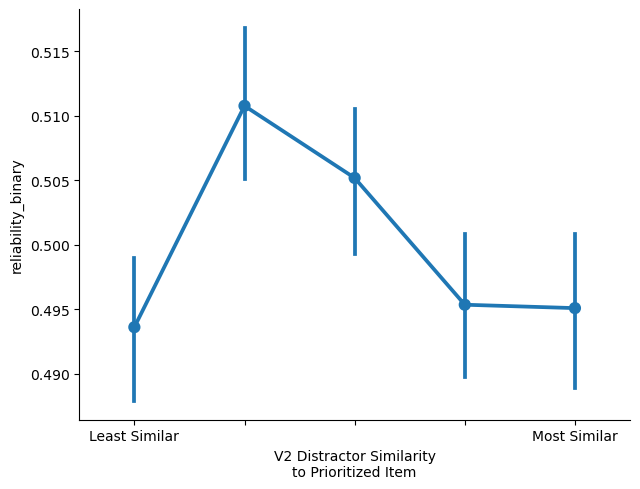

In [87]:

g = sns.catplot(
    x='V2 Distractor Similarity\nto Prioritized Item',
    y='reliability_binary',
    ci=68,
#     hue='Tested Item',
#     row='Retrocue Reliability',  # Use 'row' instead of 'col' to arrange plots vertically
    aspect=1.3,
    dodge=0.5,
    kind='point',
    row_order = ['low', 'high'],
#     palette=palette,  # Reverse the color order
    data=df)


plt.show()

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/802395013.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


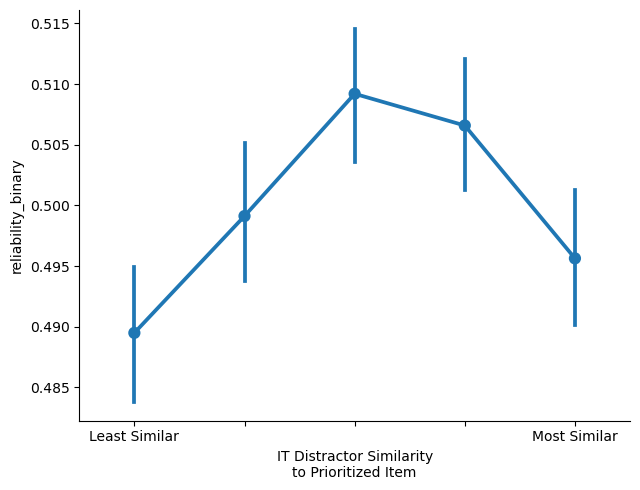

In [88]:

g = sns.catplot(
    x='IT Distractor Similarity\nto Prioritized Item',
    y='reliability_binary',
    ci=68,
#     hue='Tested Item',
#     row='Retrocue Reliability',  # Use 'row' instead of 'col' to arrange plots vertically
    aspect=1.3,
    dodge=0.5,
    kind='point',
    row_order = ['low', 'high'],
#     palette=palette,  # Reverse the color order
    data=df)


plt.show()

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/4269821370.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


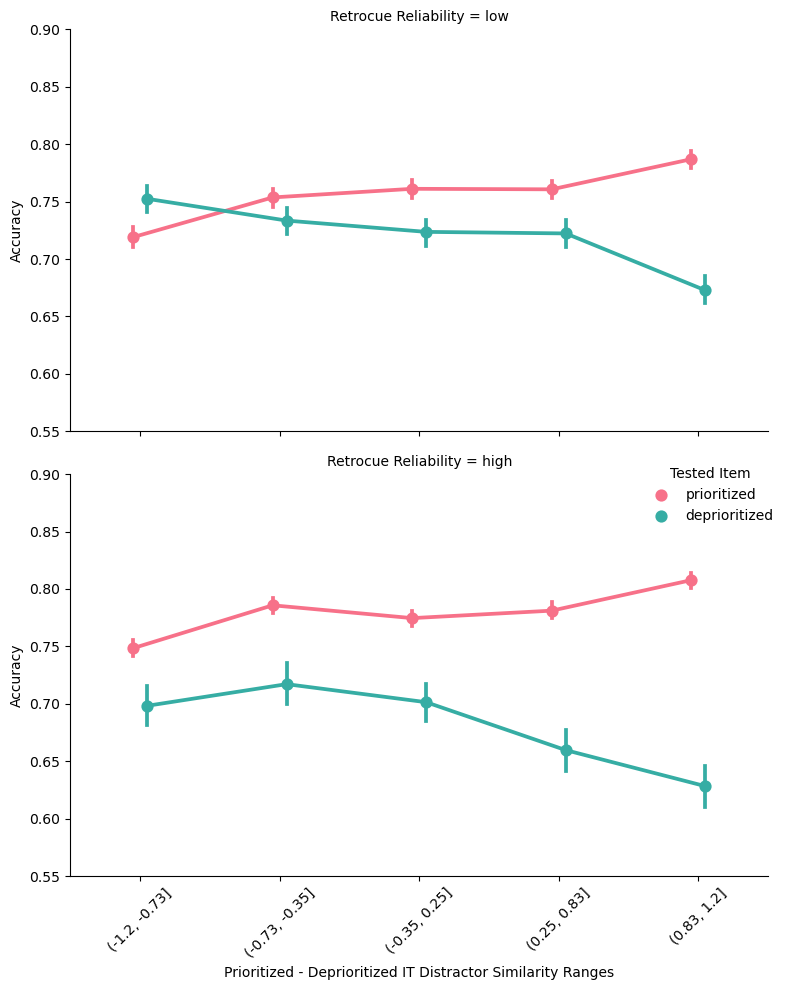

In [89]:
g = sns.catplot(
    x='Prioritized - Deprioritized IT Distractor Similarity Ranges',
    y='Accuracy',
    ci=68,
    hue='Tested Item',
    row='Retrocue Reliability',  # Use 'row' instead of 'col'
    aspect=1.3,
    row_order = ['low', 'high'],
    dodge=0.1,
    kind='point',
    palette=palette[::-1],  # Use the reversed color order
    data=df
)
g.set(ylim=(0.55, 0.9))

# Rotate the x-axis labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

g.set_axis_labels("Prioritized - Deprioritized IT Distractor Similarity Ranges", "Accuracy")
plt.tight_layout()
plt.show()

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_83887/3533399917.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  g = sns.catplot(


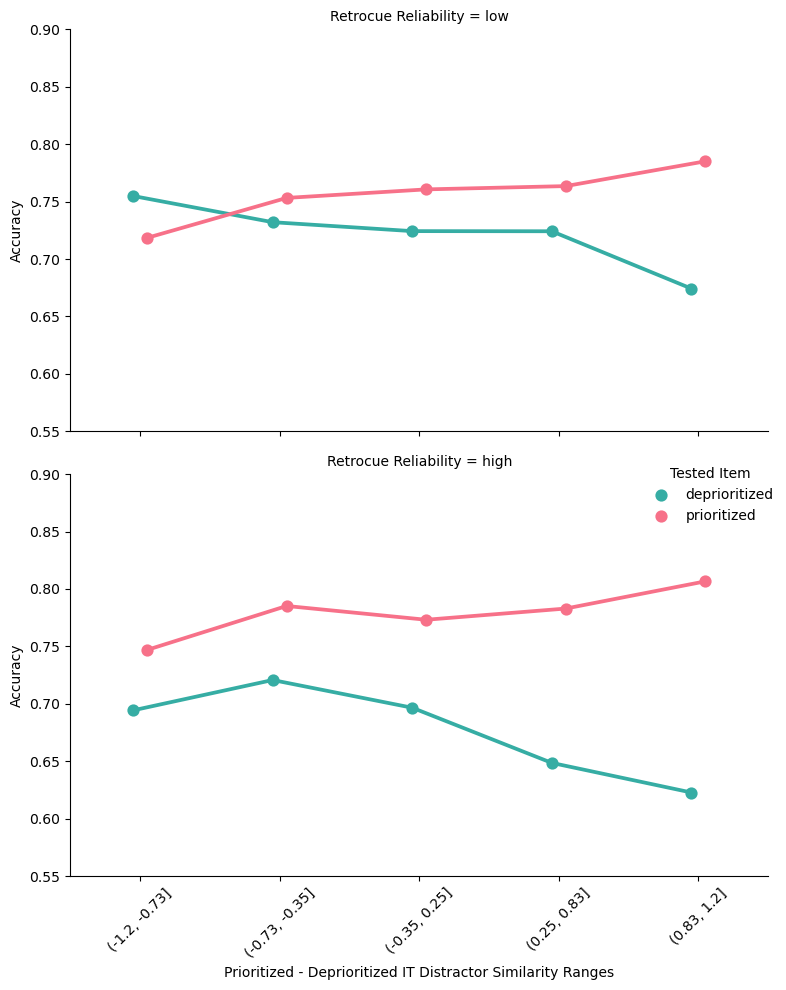

In [90]:
subject_means = df.groupby(['participant', 'Prioritized - Deprioritized IT Distractor Similarity Ranges', 'Tested Item', 'Retrocue Reliability'])['Accuracy'].mean().reset_index()

# Calculate the mean across subjects for each group
group_means = subject_means.groupby(['Prioritized - Deprioritized IT Distractor Similarity Ranges', 'Tested Item', 'Retrocue Reliability'])['Accuracy'].mean().reset_index()

# Plotting
g = sns.catplot(
    x='Prioritized - Deprioritized IT Distractor Similarity Ranges',
    y='Accuracy',
    ci=68,
    hue='Tested Item',
    row='Retrocue Reliability',  # Use 'row' instead of 'col'
    aspect=1.3,
    row_order=['low', 'high'],
    dodge=0.1,
    kind='point',
    palette=palette,  # Use the reversed color order
    data=group_means
)

# Set limits and labels
g.set(ylim=(0.55, 0.9))
g.set_axis_labels("Prioritized - Deprioritized IT Distractor Similarity Ranges", "Accuracy")

# Rotate x-axis labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()

In [91]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import matplotlib.ticker as ticker  # Import ticker here
# import pandas as pd

In [92]:

# df['Prioritized - Deprioritized IT Distractor Similarity Ranges'] = df['Prioritized - Deprioritized IT Distractor Similarity Ranges'].astype(str)

# # Preparing the subject-level mean data
# subject_means = df.groupby(['participant', 'Prioritized - Deprioritized IT Distractor Similarity Ranges', 'Tested Item'])['Accuracy'].mean().reset_index()
# group_means = subject_means.groupby(['Prioritized - Deprioritized IT Distractor Similarity Ranges', 'Tested Item'])['Accuracy'].mean().reset_index()

# # Plotting

# fig, ax = plt.subplots(figsize=(16, 24))  # Increase figure size for better visibility
# sns.set(style="ticks", rc={"lines.linewidth": 3})

# # Create a stripplot for individual subject-level means with jitter for separation
# sns.stripplot(
#     x='Prioritized - Deprioritized IT Distractor Similarity Ranges',
#     y='Accuracy',
#     data=subject_means,
#     hue='Tested Item',
#     palette=['black'],
#     marker="o",
#     jitter=True,
#     s=15,
#     zorder=10,
#     ax=ax
# )

# # Overlay the bar plot for the mean accuracy across subjects in each group
# sns.barplot(
#     x='Prioritized - Deprioritized IT Distractor Similarity Ranges',
#     y='Accuracy',
#     hue='Tested Item',
#     palette=palette[::-1],
#     data=group_means,
#     ax=ax,
#     alpha=0.6
# )

# # # Connect individual points to show change across categories for each subject
# # unique_subjects = subject_means['participant'].unique()
# # for subject in unique_subjects:
# #     subset = subject_means[subject_means['participant'] == subject]
# #     for reliability in subset['Retrocue Reliability'].unique():
# #         sub_subset = subset[subset['Retrocue Reliability'] == reliability]
# #         if sub_subset.shape[0] > 1:
# #             ax.plot(
# #                 sub_subset['Prioritized - Deprioritized IT Distractor Similarity Ranges'],
# #                 sub_subset['Accuracy'],
# #                 color="black",
# #                 alpha=0.1
# #             )

# # Customize axis and plot appearance
# handles, labels = ax.get_legend_handles_labels()
# by_label = dict(zip(labels, handles))  # Remove duplicates by creating a dictionary
# ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

# # Customize axis and plot appearance
# ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
# ax.set_ylim(0, 1)
# ax.set_xlabel("Prioritized - Deprioritized IT Distractor Similarity Ranges", fontsize=20)
# ax.set_ylabel("Accuracy", fontsize=20)
# ax.tick_params(axis='x', rotation=45, labelsize=15)
# ax.tick_params(axis='y', labelsize=15)

# fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust rect to create space for the legend
# plt.show()

In [93]:
# # Convert 'Prioritized - Deprioritized IT Distractor Similarity Ranges' to string for plotting
# df['Prioritized - Deprioritized IT Distractor Similarity Ranges'] = df['Prioritized - Deprioritized IT Distractor Similarity Ranges'].astype(str)

# # Preparing the subject-level mean data
# subject_means = df.groupby(['participant', 'Prioritized - Deprioritized IT Distractor Similarity Ranges', 'Tested Item', 'Retrocue Reliability'])['Accuracy'].mean().reset_index()
# group_means = subject_means.groupby(['Prioritized - Deprioritized IT Distractor Similarity Ranges', 'Tested Item'])['Accuracy'].mean().reset_index()

# # Define a color palette for "Retrocue Reliability" (high and low)
# # palette_retrocue = ["#1f77b4", "#ff7f0e"]  # Blue for high, Orange for low

# # Plotting
# fig, ax = plt.subplots(figsize=(16, 24))
# sns.set(style="ticks", rc={"lines.linewidth": 3})

# # Stripplot with "Retrocue Reliability" as hue to differentiate dots
# sns.stripplot(
#     x='Prioritized - Deprioritized IT Distractor Similarity Ranges',
#     y='Accuracy',
#     data=subject_means,
#     hue='Retrocue Reliability',  # Use Retrocue Reliability as hue
#     palette=palette_retrocue,
#     marker="o",
#     jitter=True,
#     s=15,
#     zorder=10,
#     ax=ax
# )

# # Overlay the bar plot for the mean accuracy across subjects in each group
# sns.barplot(
#     x='Prioritized - Deprioritized IT Distractor Similarity Ranges',
#     y='Accuracy',
#     hue='Tested Item',
#     palette=palette[::-1],
#     data=group_means,
#     ax=ax,
#     alpha=0.6
# )

# # Clean up the legend to avoid duplicates
# handles, labels = ax.get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

# # Customize axis and plot appearance
# ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
# ax.set_ylim(0, 1)
# ax.set_xlabel("Prioritized - Deprioritized IT Distractor Similarity Ranges", fontsize=20)
# ax.set_ylabel("Accuracy", fontsize=20)
# ax.tick_params(axis='x', rotation=45, labelsize=15)
# ax.tick_params(axis='y', labelsize=15)

# fig.tight_layout(rect=[0, 0, 1, 1])  # Adjust rect to create space for the legend
# plt.show()


In [94]:
# # Preparing the subject-level mean data without Prioritized - Deprioritized IT Distractor Similarity Ranges
# subject_means = df.groupby(['participant', 'Tested Item', 'Retrocue Reliability'])['Accuracy'].mean().reset_index()
# group_means = subject_means.groupby(['Tested Item'])['Accuracy'].mean().reset_index()

# # Define a color palette for "Retrocue Reliability" (high and low) using blue and orange
# palette_retrocue = ["#1f77b4", "#ff7f0e"]  # Blue for high, Orange for low

# # Plotting
# fig, ax = plt.subplots(figsize=(16, 24))
# sns.set(style="ticks", rc={"lines.linewidth": 3})

# # Stripplot with "Retrocue Reliability" as hue to differentiate dots
# sns.stripplot(
#     x='Tested Item',  # Changed x-axis to Tested Item
#     y='Accuracy',
#     data=subject_means,
#     hue='Retrocue Reliability',  # Use Retrocue Reliability as hue
#     palette=palette_retrocue,
#     marker="o",
#     jitter=True,
#     s=15,
#     zorder=10,
#     ax=ax
# )

# # Overlay the bar plot for the mean accuracy across subjects in each group without hue
# sns.barplot(
#     x='Tested Item',  # Changed x-axis to Tested Item
#     y='Accuracy',
#     data=group_means,
#     ax=ax,
# #     color='gray'/,  # Single color for bar plot
#     alpha=0.6
# )

# # Clean up the legend to avoid duplicates
# handles, labels = ax.get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

# # Customize axis and plot appearance
# ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
# ax.set_ylim(0, 1)
# ax.set_xlabel("Tested Item", fontsize=20)  # Updated x-axis label
# ax.set_ylabel("Accuracy", fontsize=20)
# ax.tick_params(axis='x', rotation=45, labelsize=15)
# ax.tick_params(axis='y', labelsize=15)

# fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust rect to create space for the legend
# plt.show()


In [95]:
# df

In [96]:
# df.to_csv("df_stats5.csv", index=False)


In [97]:
# df['it_sim_dis_diff']= df['Prioritized - Deprioritized IT Distractor Similarity Ranges']

In [98]:
# md = smf.glm(
#     "resp_correct ~ it_sim_dis_diff*reliability*validity \
#         + v2_sim_dis_diff*reliability*validity",
#     data=df,
#     family=sm.families.Binomial()  
# ).fit()

# # View the summary
# md.summary()